# Predicting sentiment of smartphone reviews from Ukrainian eCommerce marketplace

The project will be focusing on exploration of smartphone reviews data from Ukrainian eCommerce marketplace Rozetka.ua.
After inspecting the web-site https://rozetka.com.ua/ I noticed that not all reviews have rating. 
If the fraction of such reviews without rating is significant - it may be useful to build a prediction model to fill in missing ratings which will allow to see more complete picture of overall sentiment of Ukrainian consumers toward specific products categories, brands, products within specific price range, etc.
The purpose of this project is to check the feasibility of the idea and if it’s possible to build a model to predict a sentiment of the  reviews with the high enough accuracy. Here we will focus on Smartphones product category reviews.
It’s also possible to apply the same approach to other product categories, but it’s advisable to train separate models for different categories so model can learn reviews specifics of particular type of products.

**Few words about marketplace Rozetka.ua data from which we will explore** :
Rozetka.ua is a Ukrainian online store and marketplace that was founded in 2005. As of August 2020, the site ranks 7th among the most visited in Ukraine. 
Initially, the store sold household appliances and electronics, but today you can find there many more categories of goods - from clothing to food. A total of 3.9 million products are presented on the site. It is visited daily by 2.5 million people. Such success was achieved, including through the involvement of third-party sellers. At Rozetka, they generate 25% of sales. In addition to the marketplace, Rozetka has launched its own network of retail stores, delivers to its post offices and mobile delivery points, and entered the international market.
Being one of the biggest marketplaces in Ukraine, Rozetka.ua also became a site with the biggest number of reviews from consumers in Ukraine on wide range of products. This combined with fast and seamless service is allowing Rozetka to retain leading positions in Ukrainian eCommerce retail market.

# Step 1: Data collection 

The first step is to retrieve the product reviews data. 
The search for possibility to export reviews from web-site or to use exciting browser extension/plugin didn’t bring results, so it was decided to collect the data using web-scraping (scrappy module in python).
The script which retrieves necessary data and writes it into the “smartphone_reviews.csv” file is located in separate notebook “Scraping_reviews.ipynb”.

*The developed  web-scraping script does not retrieve all available reviews. It is caused by the fact that web-pages are generated dynamically with “Show more” button. To solve this problem, it’s necessary to use tools like Selenium, which can interact with web-pages to get full data previously to parsing html. 
Here we will proceed with the data generated with the scrapy module functionality as it should be enough for purposes of this project.

# Step 2: Read dataset and perform basic preprocessing

## Read and explore dataset

In [1]:
#Import necessary libraries

#! pip install dateparser 
#!pip install advertools
#!pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import dateparser
from datetime import timedelta
from datetime import date
import ktrain
from ktrain import text
import advertools as adv
from langdetect import detect
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

%config IPCompleter.greedy=True

#Remove limitations for displaying of tables in pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

In [355]:
#Get list of files names
files_names = glob.glob("*.csv")

#Iterate through retrieved file names to read files into DataFrames.
#Replace "today" and "yesterday" values in review_date with corresponding dates.
df_names = []
for i, j in enumerate(files_names):
    date = datetime.strptime(j.split('smartphone_reviews_')[1].split('.csv')[0], '%Y-%m-%d')
    date_yesterday = date - timedelta(1)
    data = pd.read_csv(files_names[i])
    data['review_date'] = [i.replace('сьогодні', str(date)) if 'сьогодні' in i else i for i in data['review_date']]
    data['review_date'] = [i.replace('вчора', str(date_yesterday)) if 'вчора' in i else i for i in data['review_date']]
    globals()['data_%s' % i] = data
    print('DataFrame {} was added'.format('data_%s' % i))
    df_names.append(globals()['data_%s' % i])

DataFrame data_0 was added
DataFrame data_1 was added


In [356]:
#Concatenate DataFrames and drop duplicates
data = pd.concat(df_names)
data.drop_duplicates(subset=['review_id'], inplace=True)

In [357]:
#Look at short info of DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6499 entries, 0 to 5430
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   product_link                     6499 non-null   object 
 1   product_title                    6499 non-null   object 
 2   product_price                    6499 non-null   float64
 3   review_id                        6499 non-null   int64  
 4   review_date                      6499 non-null   object 
 5   review_text                      6499 non-null   object 
 6   review_rating                    6499 non-null   int64  
 7   thumbs_up                        6499 non-null   int64  
 8   thumbs_down                      6499 non-null   int64  
 9   product_advatages_disadvantages  6499 non-null   object 
 10  product_advatages                6499 non-null   object 
 11  product_disadvantages            6498 non-null   object 
dtypes: float64(1), int64

In [358]:
#Unique values count for all columns
for i in data.columns:
   print("{} -- {} unique values".format(i, len(data[i].unique())))

product_link -- 914 unique values
product_title -- 792 unique values
product_price -- 344 unique values
review_id -- 6499 unique values
review_date -- 1101 unique values
review_text -- 6151 unique values
review_rating -- 6 unique values
thumbs_up -- 81 unique values
thumbs_down -- 56 unique values
product_advatages_disadvantages -- 3541 unique values
product_advatages -- 3288 unique values
product_disadvantages -- 2548 unique values


In [359]:
#Check unique values for columns with <100 unique values
for i in ['review_rating', 'thumbs_up', 'thumbs_down']:
    print(data[i].value_counts())

0    2964
5    2147
4    561 
1    409 
3    223 
2    195 
Name: review_rating, dtype: int64
0      3257
1      1198
2      571 
3      352 
4      201 
5      144 
6      97  
7      79  
13     52  
10     41  
8      40  
9      39  
12     36  
11     29  
14     25  
18     25  
16     21  
17     21  
20     19  
19     18  
15     18  
23     15  
24     13  
22     13  
21     12  
25     10  
30     9   
27     8   
26     7   
36     6   
56     6   
29     5   
41     5   
37     5   
35     5   
31     5   
40     5   
38     4   
39     4   
33     4   
32     4   
34     3   
43     3   
62     3   
44     3   
79     3   
54     3   
42     3   
48     3   
64     2   
28     2   
52     2   
113    2   
46     2   
53     2   
57     2   
63     2   
69     2   
73     2   
77     2   
58     2   
50     2   
49     2   
98     2   
114    1   
55     1   
158    1   
47     1   
86     1   
59     1   
94     1   
45     1   
82     1   
129    1   
101    1   
80    

## Fix data format, parsing issues, check for duplicates

From the head of the dataset and statistics we can see:
- product_link, product_title, product_price, review_id, review_rating, thumbs_up, product_disadvantages – these columns looks good
- review_date – needs to be converted to datatime format
- review_text – lets look at records with the same text to check for duplicates
- product_advatages_disadvantages – this column is duplicating, it was left in the scaping script in case there is a need to  check we have full information in product_advatages/ product_disadvantages clolumns. Seems like everything is fine, so we can drop this column.
- product_advatages – we need to strip redundant symbols from this column and leave only text about product advantages, we can do this by striping everything after ‘/dd></div>’

Also let’s add a column which will contain all text related to the review: combination of review_text, product_advatages, product_disadvantages columns, so we can use it later on modeling stage.

In [360]:
#Lets have a closer look at format of review_date values
print(data.review_date.value_counts()[:30])

 2021-03-06 00:00:00     76
 20 лютого 2021          74
 02 березня 2021         63
 01 березня 2021         60
 18 лютого 2021          59
 21 лютого 2021          58
 17 лютого 2021          58
 15 лютого 2021          53
 22 лютого 2021          53
 03 березня 2021         52
 04 березня 2021         50
 25 лютого 2021          48
 27 лютого 2021          48
 16 лютого 2021          47
 2021-02-23 00:00:00     45
 13 лютого 2021          45
 05 березня 2021         45
 10 лютого 2021          45
 28 лютого 2021          44
 19 лютого 2021          44
 14 лютого 2021          44
 08 лютого 2021          44
 09 лютого 2021          42
 24 лютого 2021          41
 26 лютого 2021          40
 12 лютого 2021          35
 2021-03-07 00:00:00     33
 07 лютого 2021          33
 06 лютого 2021          31
 11 лютого 2021          30
Name: review_date, dtype: int64


In [361]:
#Convert review_date to datetime format and look at the results
data.review_date = [dateparser.parse(date, date_formats=['%d %m %Y']) for date in data.review_date]
print(data.review_date.value_counts()[:30])

2021-03-06    76
2021-02-20    74
2021-03-02    63
2021-03-01    60
2021-02-18    59
2021-02-17    58
2021-02-21    58
2021-02-22    53
2021-02-15    53
2021-03-03    52
2021-02-23    50
2021-03-04    50
2021-02-25    48
2021-02-27    48
2021-02-16    47
2021-02-13    45
2021-03-05    45
2021-02-10    45
2021-02-28    44
2021-02-14    44
2021-02-19    44
2021-02-08    44
2021-02-24    43
2021-02-09    42
2021-02-26    40
2021-02-12    35
2021-02-07    33
2021-03-07    33
2021-02-06    31
2021-02-11    30
Name: review_date, dtype: int64


In [362]:
#review_text – look at records with the same text to check for duplicates
display(pd.concat(g for _, g in data.groupby("review_text") if len(g) > 1))

product_link  \
2281  https://rozetka.com.ua/ua/xiaomi_660926/p244791781/comments/#id=49381841                                           
266   https://rozetka.com.ua/ua/xiaomi_660925/p244791319/comments/#id=49222920                                           
1701  https://rozetka.com.ua/ua/samsung_sm_a207fzrdsek/p138459953/comments/#id=48220537                                  
2234  https://rozetka.com.ua/ua/samsung_sm_m115fzknsek/p208369267/comments/#id=49024804                                  
4979  https://rozetka.com.ua/ua/15968704/p15968704/comments/#id=19836895                                                 
5656  https://rozetka.com.ua/ua/33763271/p33763271/comments/#id=47530837                                                 
4580  https://rozetka.com.ua/ua/39174216/p39174216/comments/#id=42818294                                                 
5252  https://rozetka.com.ua/ua/44037392/p44037392/comments/#id=31681958                                                 
69    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                        
93    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49229688                                  
95    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49229688                                  
144   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49393488                                  
175   https://rozetka.com.ua/ua/samsung_galaxy_m51_6_128gb_black/p249014389/comments/#id=49341901                        
252   https://rozetka.com.ua/ua/motorola_page0015rs/p245661253/comments/#id=49220436                                     
256   https://rozetka.com.ua/ua/motorola_page0015rs/p245661253/comments/#id=49220436                                     
301   https://rozetka.com.ua/ua/huawei_p40_lite_6_128_black/p190067606/comments/#id=49306749                             
390   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_3_64gb_midnight_grey/p209754337/comments/#id=49359517                
426   https://rozetka.com.ua/ua/zte_blade_a7s_3_64gb_blue/p250624431/comments/#id=49395365                               
446   https://rozetka.com.ua/ua/samsung_sm_a107fdbdsek/p272332106/comments/#id=44488094                                  
458   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_pro_6_64gb_tropical_green/p209755855/comments/#id=49348935           
461   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_pro_6_64gb_tropical_green/p209755855/comments/#id=49348935           
472   https://rozetka.com.ua/ua/realme_2001000187010/p208543585/comments/#id=49396108                                    
480   https://rozetka.com.ua/ua/zte_blade_a7_2020_2_32gb_black/p155606256/comments/#id=49386268                          
486   https://rozetka.com.ua/ua/zte_blade_a7_2020_2_32gb_black/p155606256/comments/#id=49386268                          
524   https://rozetka.com.ua/ua/huawei_51095kyp/p217174627/comments/#id=49303091                                         
533   https://rozetka.com.ua/ua/huawei_51095kyp/p217174627/comments/#id=49303091                                         
584   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_4_128gb_midnight_grey/p209755831/comments/#id=49350308               
678   https://rozetka.com.ua/ua/huawei_p40_pro_8_256gb_silver_slim_box/p270684826/comments/#id=49369839                  
821   https://rozetka.com.ua/ua/apple_mhdm3/p260937056/comments/#id=49077362                                             
914   https://rozetka.com.ua/ua/samsung_sm_g780flvdsek/p250175966/comments/#id=48567525                                  
982   https://rozetka.com.ua/ua/xiaomi_redmi_note_8_pro_6_128gb_black/p124473030/comments/#id=49315341                   
1004  https://rozetka.com.ua/ua/samsung_galaxy_a01_core_1_16gb_blue/p243490447/comments/#id=48723345                     
1053  https://rozetka.com.ua/ua/samsung_galaxy_s20_ultra_gray_sm_g988bzadsek/p18

In [363]:
#lets remove "None" values from the result
display(pd.concat(g for _, g in data.groupby("review_text") if len(g) > 1 and g is not 'None'))
#After examining records with same review text we can make a conclusion that they are unique

<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-363-2d7b7eb45dab>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  display(pd.concat(g for _, g in data.groupby("review_text") if len(g) > 1 and g is not 'None'))


product_link  \
2281  https://rozetka.com.ua/ua/xiaomi_660926/p244791781/comments/#id=49381841                                           
266   https://rozetka.com.ua/ua/xiaomi_660925/p244791319/comments/#id=49222920                                           
1701  https://rozetka.com.ua/ua/samsung_sm_a207fzrdsek/p138459953/comments/#id=48220537                                  
2234  https://rozetka.com.ua/ua/samsung_sm_m115fzknsek/p208369267/comments/#id=49024804                                  
4979  https://rozetka.com.ua/ua/15968704/p15968704/comments/#id=19836895                                                 
5656  https://rozetka.com.ua/ua/33763271/p33763271/comments/#id=47530837                                                 
4580  https://rozetka.com.ua/ua/39174216/p39174216/comments/#id=42818294                                                 
5252  https://rozetka.com.ua/ua/44037392/p44037392/comments/#id=31681958                                                 
69    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                        
93    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49229688                                  
95    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49229688                                  
144   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49393488                                  
175   https://rozetka.com.ua/ua/samsung_galaxy_m51_6_128gb_black/p249014389/comments/#id=49341901                        
252   https://rozetka.com.ua/ua/motorola_page0015rs/p245661253/comments/#id=49220436                                     
256   https://rozetka.com.ua/ua/motorola_page0015rs/p245661253/comments/#id=49220436                                     
301   https://rozetka.com.ua/ua/huawei_p40_lite_6_128_black/p190067606/comments/#id=49306749                             
390   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_3_64gb_midnight_grey/p209754337/comments/#id=49359517                
426   https://rozetka.com.ua/ua/zte_blade_a7s_3_64gb_blue/p250624431/comments/#id=49395365                               
446   https://rozetka.com.ua/ua/samsung_sm_a107fdbdsek/p272332106/comments/#id=44488094                                  
458   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_pro_6_64gb_tropical_green/p209755855/comments/#id=49348935           
461   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_pro_6_64gb_tropical_green/p209755855/comments/#id=49348935           
472   https://rozetka.com.ua/ua/realme_2001000187010/p208543585/comments/#id=49396108                                    
480   https://rozetka.com.ua/ua/zte_blade_a7_2020_2_32gb_black/p155606256/comments/#id=49386268                          
486   https://rozetka.com.ua/ua/zte_blade_a7_2020_2_32gb_black/p155606256/comments/#id=49386268                          
524   https://rozetka.com.ua/ua/huawei_51095kyp/p217174627/comments/#id=49303091                                         
533   https://rozetka.com.ua/ua/huawei_51095kyp/p217174627/comments/#id=49303091                                         
584   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_4_128gb_midnight_grey/p209755831/comments/#id=49350308               
678   https://rozetka.com.ua/ua/huawei_p40_pro_8_256gb_silver_slim_box/p270684826/comments/#id=49369839                  
821   https://rozetka.com.ua/ua/apple_mhdm3/p260937056/comments/#id=49077362                                             
914   https://rozetka.com.ua/ua/samsung_sm_g780flvdsek/p250175966/comments/#id=48567525                                  
982   https://rozetka.com.ua/ua/xiaomi_redmi_note_8_pro_6_128gb_black/p124473030/comments/#id=49315341                   
1004  https://rozetka.com.ua/ua/samsung_galaxy_a01_core_1_16gb_blue/p243490447/comments/#id=48723345                     
1053  https://rozetka.com.ua/ua/samsung_galaxy_s20_ultra_gray_sm_g988bzadsek/p18

In [364]:
#Delete product_advatages_disadvantages column
data = data.drop(columns=['product_advatages_disadvantages'])

In [365]:
#Fix parsing of product_advatages column
data.product_advatages = [i.split('</dd>')[0] if i != "None" else 'None' for i in data.product_advatages]
display(data.head())

product_link  \
0  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
1  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
2  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
3  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
4  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   

                                                                                                                 product_title  \
0   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
1   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
2   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
3   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
4   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    

   product_price  review_id review_date  \
0  39999.0        49293156  2021-02-13    
1  39999.0        49190491  2021-02-04    
2  39999.0        49299159  2021-02-14    
3  39999.0        49289173  2021-02-13    
4  39999.0        49224598  2021-02-07    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          review_text  \
0  Розетка, подскажите телефон без сканера лица и желательно без сканера отпечатков пальцев. Спасибо                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
1  Датчик адаптивной яркости работает не корректно в темноте дисплей светит на 90 процентов. Когда тресешь телефон раздается звук как будто внутри что то отвалилось, до этого s9 plus таких проблем не было, да Самсунг уже не тот))                                                                                                                                                   

## Check review_text content to drop rows with not enough information 

During checking reviews content, I noticed that some reviews seem to be quite low-quality. Usually such reviews contained questions instead of actual review or they contained very short text. Lets check these 2 cases.

In [366]:
#Check review_text with questions
qestions = []
for i in data.review_text:
    if str(i).endswith('?') and (len(i)<170):
        qestions.append(i)
        
print(len(qestions))
display(data[data['review_text'].isin(qestions)])

#After examining different lengths of questions in review_text column it was decided to use 180 symbols as threshold.
#Most of questions below this length doesn’t contain sentiment about product, just question. Some records have advatages/disadvantages description, but since there is not may of them - we will just drop such rows.
data = data[~data['review_text'].isin(qestions)]

1283


product_link  \
3     https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834              
4     https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834              
14    https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49366754                                        
20    https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49366754                                        
38    https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49345727                                       
44    https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49345727                                       
47    https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49389613                                       
52    https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49389613                                       
58    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                             
59    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                             
84    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49229688                                       
87    https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49229688                                       
97    https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49374060                                       
98    https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49374060                                       
101   https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49374060                                       
102   https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49374060                                       
104   https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49374060                                       
107   https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49374060                                       
109   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=48224420                             
115   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=48224420                             
116   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=48224420                             
117   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=48224420                             
122   https://rozetka.com.ua/ua/motorola_pajw0006rs/p245662303/comments/#id=49393323                                          
134   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49393488                                       
137   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49393488                                       
140   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49393488                                       
142   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49393488                                       
145   https://rozetka.com.ua/ua/samsung_sm_a315fzbusek/p199325431/comments/#id=49393488                                       
147   https://rozetka.com.ua/ua/xiaomi_657896/p224125945/comments/#id=47507593                                                
153   https://rozetka.com.ua/ua/xiaomi_657896/p224125945/comments/#id=47507593                                                
157   https://rozetka.com.ua/ua/xiaomi_657896/p224125945/comments/#id=47507593                                                
173   https://rozetka.com.ua/ua/samsung_galaxy_

In [367]:
#Check short review_text values
short_comments = []
for i in data.review_text:
    if (len(str(i))<2) and i not in qestions and i!='None':
        short_comments.append(i)
        
print(len(short_comments))
display(data[data['review_text'].isin(short_comments)])

#After examining short reviews it was decided to leave them as a lot of short reviews contained reviewer opinion on the product.
#We will drop only rows with extremely short text, below 2 symbols.
data = data[~data['review_text'].isin(short_comments)]

2


product_link  \
4979  https://rozetka.com.ua/ua/15968704/p15968704/comments/#id=19836895   
5656  https://rozetka.com.ua/ua/33763271/p33763271/comments/#id=47530837   

                      product_title  product_price  review_id review_date  \
4979   S-TELL M556 Black             1999.0         19335260  2017-07-12    
5656   Blackview A10 Barley Golden   2086.0         32563944  2018-09-13    

     review_text  review_rating  thumbs_up  thumbs_down  \
4979  .           0              0          0             
5656  .           4              0          0             

                                                                                                                                                                              product_advatages  \
4979  Неплохая камера для телефона за 70$ ,экран хоть и большеват для такого разрешения но лесенок и пикселей не наблюдается,стекло довольно прочное,технология miravision,углы обзора экрана,.   
5656  None                                                                                                                                                                                        

                                                                                                                                                                   product_disadvantages  
4979  Перегрев,он выгружает фоновые приложения из памяти,плохое стандартное приложение камеры ,поганая оптимизация системы , баги системы,динамик тихий ,скользящий задник смартфона   ,  
5656  None

## Create column full_text which contains all text related  to the review: review_text, product_advatages, product_disadvantages

In [368]:
#Create full_text column
data["full_text"] = data["review_text"] +' Преймущества: ' +data["product_advatages"] + '. Недостатки: ' + data.product_disadvantages

## Take care of Missing values

review_rating
0    1793
1    395 
2    188 
3    217 
4    538 
5    2083
Name: product_link, dtype: int64

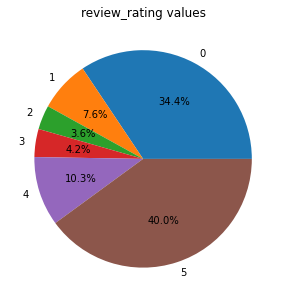

In [369]:
#At first let's look at review_rating values count
display(data.groupby('review_rating')['product_link'].count())
#Plot a diagram of review_rating values count
labels, frequencies = np.unique(data.review_rating.values, return_counts = True)
plt.figure(figsize = (5, 5))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title('review_rating values')
plt.show()

From checking the web-site we can see that there are no reviews with 0 stars, so in fact 35% of retrieved reviews don’t have a rating. It confirms that predicting sentiment of reviews based on text can be useful, it will allow to get the information about consumers sentiment for significant fraction of the reviews that currently are not classified. 

In [370]:
#During web-scraping script preparation missing values were marked as None. 
#Lets set 0 in review_rating and None in other columns as NaN 
#Also lets set as NaN values of full_text column in which we don’t have any text
data['review_rating'] = data['review_rating'].replace(0, np.NaN)
data = data.replace('None', np.NaN)
data['full_text'] = data['full_text'].replace('None Преймущества: None. Недостатки: None', np.NaN)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5214 entries, 0 to 5430
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   product_link           5214 non-null   object        
 1   product_title          5214 non-null   object        
 2   product_price          5214 non-null   float64       
 3   review_id              5214 non-null   int64         
 4   review_date            5214 non-null   datetime64[ns]
 5   review_text            4960 non-null   object        
 6   review_rating          3421 non-null   float64       
 7   thumbs_up              5214 non-null   int64         
 8   thumbs_down            5214 non-null   int64         
 9   product_advatages      3267 non-null   object        
 10  product_disadvantages  3249 non-null   object        
 11  full_text              5065 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory u

# Step 3: Exploratory data analysis 

In this section, we will make a cursory exploration of retrieved reviews data.

##  review_rating exploration  

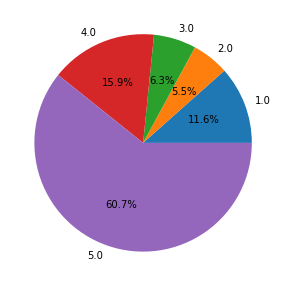

In [234]:
#Plot review_rating values
data_wth_rating = pd.DataFrame(data[data.review_rating.notna()])
labels, frequencies = np.unique(data_wth_rating.review_rating.values, return_counts = True)
plt.figure(figsize = (5,5))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

*The target variable classes are imbalanced.
We can see that the biggest fraction of reviews is the most positive ones: almost 60% percent of reviews have rating 5 stars and the second biggest fraction is also positive reviews with the rating of 4 stars.*

## product_price VS review_rating relation   

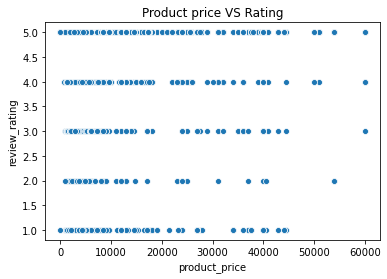

In [235]:
#Visualize relation of Product price VS Rating
ax = sns.scatterplot(data=data_wth_rating, x="product_price", y="review_rating")
ax.set_title('Product price VS Rating')
plt.show()

*From the plot above we can see that more expensive products seem to have tendency to have higher ratings.
To see the trend more clearly lets divide products into 4 price segments and plot average rating.*

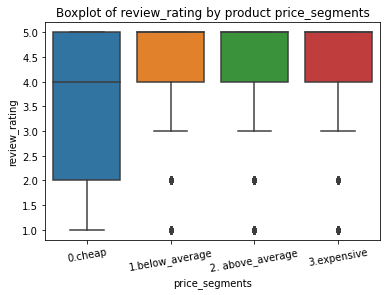

review_rating
price_segments                 
0.cheap           3.578775     
1.below_average   4.071346     
2. above_average  4.291954     
3.expensive       4.426304

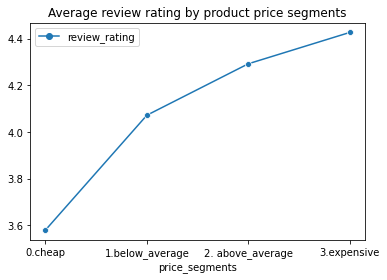

In [236]:
#Plot review_rating in product price_segments
data_wth_rating['price_segments'] = pd.qcut(data_wth_rating.product_price, 4, labels=["0.cheap", "1.below_average", "2. above_average", "3.expensive"])
ax =sns.boxplot(x="price_segments", y="review_rating", data=data_wth_rating)
plt.setp(ax.get_xticklabels(), rotation=10)
ax.set_title('Boxplot of review_rating by product price_segments')
plt.show()

#Create price segments and check avarage rating 
review_rating_by_price_segments = pd.DataFrame(data_wth_rating.groupby('price_segments')['review_rating'].mean())
display(review_rating_by_price_segments)
g = sns.lineplot(data=review_rating_by_price_segments, markers=True)
g.set_title('Average review rating by product price segments')
plt.show()

## review_date VS review_date relation   

'The earliest review is from 2015 year and the latest review is from 2021 year'

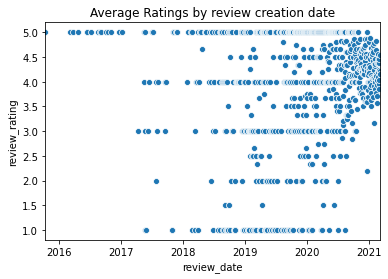

In [237]:
#Explore reviews cretion timeline
display("The earliest review is from {} year and the latest review is from {} year".format(data.review_date.min().year, data.review_date.max().year))

rating_avg = data_wth_rating.groupby('review_date')['review_rating'].mean().reset_index()
ax = sns.scatterplot(data = rating_avg, x='review_date', y='review_rating')
ax.set_title('Average Ratings by review creation date')
ax.set(xlim=(data_wth_rating.review_date.min(), data_wth_rating.review_date.max()))
plt.show()

*From the plot above we can see that in our dataset there are much more newer reviews than old ones and newer reviews also seem to have higher ratings. 
Probably it’s connected with the way how reviews were web-scraped: we retrieved only first portion of reviews of each product that was initially displayed in the web-page (before pressing “Show more” button).  It’s could be the web-site will show the recent and positive reviews first and it will explain why we got mainly recent positive reviews.*

Even though there is some specifics of how data was collected it should be good enough to test what performance we can expect from the sentiment prediction model, so we can proceed further with the project.

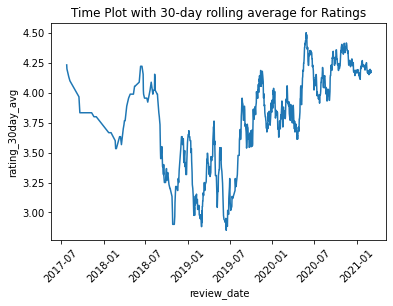

In [351]:
#Explore reviews timeline with rolling mean to see if there is a trend
rating_avg['rating_30day_avg'] = rating_avg.review_rating.rolling(30).mean().shift(-3)
ax = sns.lineplot(data = rating_avg, x='review_date', y='rating_30day_avg')
ax.set_title('Time Plot with 30-day rolling average for Ratings')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

*The plot above with 30-day rolling average removes noise from the data and show more general trend of how average ratings in our dataset have been changing in time. Seems like average rating for smartphones grows up since summer 2019.*

## review_text - language detection

In [242]:
#Drop rows with NA values for review_text
review_text_clean = pd.DataFrame(data_wth_rating.dropna(subset = ['review_text']))

#Detect language
lang=[]
for i in review_text_clean.review_text:
    try:
      lang.append(detect(i))
    except:
        lang.append('None')
review_text_clean['lang'] = lang

lang=[]
for i in review_text_clean.review_text:
    try:
        b = TextBlob(i)  
        lang.append(b.detect_language())
    except:
        lang.append('None')
review_text_clean['lang'] = lang


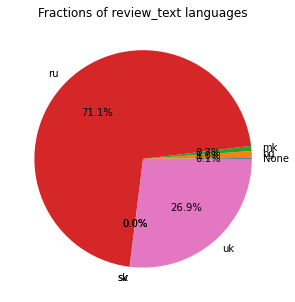

In [243]:
#Plot fractions of detected review_text languages
labels, frequencies = np.unique(review_text_clean.lang.values, return_counts = True)
plt.figure(figsize = (5, 5))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title('Fractions of review_text languages')
plt.show()

In [244]:
#Look at rows which was not detected as ru or uk language
review_text_clean[(review_text_clean.lang != 'ru') & (review_text_clean.lang != 'uk')]

product_link  \
50    https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49389613                             
60    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                   
62    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                   
78    https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49291997                  
97    https://rozetka.com.ua/ua/samsung_sm_g975fckdsek/p211792951/comments/#id=49374060                             
110   https://rozetka.com.ua/ua/realme_7_pro_8_128gb_mirror_blue/p254407693/comments/#id=48224420                   
314   https://rozetka.com.ua/ua/zte_blade_a7_2_32gb_black/p90749888/comments/#id=44041004                           
359   https://rozetka.com.ua/ua/xiaomi_657892/p224063905/comments/#id=49180580                                      
430   https://rozetka.com.ua/ua/zte_blade_a7s_3_64gb_blue/p250624431/comments/#id=49395365                          
766   https://rozetka.com.ua/ua/motorola_razr_5g_gold/p247505413/comments/#id=48728001                              
862   https://rozetka.com.ua/ua/apple_iphone_12_pro_max_256gb_pacific_blue/p245162569/comments/#id=49203871         
968   https://rozetka.com.ua/ua/xiaomi_mi_10t_lite_6_128gb_rose_gold_beach/p252723166/comments/#id=47760607         
1036  https://rozetka.com.ua/ua/pocophone_691532/p246763123/comments/#id=49365662                                   
1308  https://rozetka.com.ua/ua/tecno_spark_6_4_64gb_comet_black/p261915406/comments/#id=49367005                   
1357  https://rozetka.com.ua/ua/tecno_spark_6_4_128gb_ocean_blue/p261922161/comments/#id=49262431                   
1391  https://rozetka.com.ua/ua/samsung_sm_n985fzkgsek/p238667365/comments/#id=48922846                             
1422  https://rozetka.com.ua/ua/ulefone_armor_x6_2_16gb_black_orange/p174142613/comments/#id=48670762               
1794  https://rozetka.com.ua/ua/61852957/p61852957/comments/#id=48470597                                            
1798  https://rozetka.com.ua/ua/61852957/p61852957/comments/#id=48470597                                            
1894  https://rozetka.com.ua/ua/83793234/p83793234/comments/#id=45130210                                            
2029  https://rozetka.com.ua/ua/xiaomi_mi_10_8_128gb_peach_gold/p185481269/comments/#id=47710022                    
2110  https://rozetka.com.ua/ua/samsung_galaxy_m31_6_128gb_blue/p175401451/comments/#id=49289159                    
2163  https://rozetka.com.ua/ua/meizu_16_6_64gb_black/p154384749/comments/#id=48832737                              
2202  https://rozetka.com.ua/ua/samsung_galaxy_a01_2_16gb_red/p173920111/comments/#id=49133920                      
2216  https://rozetka.com.ua/ua/nokia_2_3_2_32gb_black/p159096638/comments/#id=48873913                             
2234  https://rozetka.com.ua/ua/samsung_sm_m115fzknsek/p208369267/comments/#id=49024804                             
2270  https://rozetka.com.ua/ua/oppo_a31_lake_green/p193260096/comments/#id=49076790                                
2361  https://rozetka.com.ua/ua/samsung_galaxy_s20_red_sm_g980fzrdsek/p183270221/comments/#id=48836608              
2414  https://rozetka.com.ua/ua/realme_6941399004832/p208489687/comments/#id=49057799                               
2453  https://rozetka.com.ua/ua/huawei_y6_2019_blue/p76631166/comments/#id=43736180                                 
2717  https://rozetka.com.ua/ua/2e_e450a_2018_dualsim_black/p51927996/comments/#id=47703376                         
2809  https://rozetka.com.ua/ua/meizu_m6t_3_32gb_blue/p216463345/comments/#id=47146152                              
2852  https://rozetka.com.ua/ua/realme_6941399000230/p237047725/comments/#id=47912607                               
2919  https://rozetka.com.ua/ua/oppo_find_x2_ocean_black/p194528244/comments/#id=47435225                           
3154  

*From inspecting the table above we can make conclusion that language for some records was not detected correctly: some reviews in Russian and Ukrainian were wrongly classified as other languages (Bulgarian, Macedonian, Rumanian, etc). 
Since the fraction of misclassified records is nor significant, we still can conclude that about ¾ of all reviews are written in Russian and ¼ in Ukrainian languages.*

## review_text exploration - Unigrams, Bigrams, Trigrams

In this section we will explore the most common words and phrases in the review_text column for positive and negative reviews.  To do so we will create the new column review_sentiment which will correspond to the value “1” for positive reviews (with 4 and 5 stars) and “0” for negative reviews (with 1, 2 and 3 stars).

In [245]:
#Create review_sentiment to show negative and positive reviews
data_wth_rating.loc[(data_wth_rating['review_rating']==1)|(data_wth_rating['review_rating']==2)|(data_wth_rating['review_rating']==3), 'review_sentiment'] = '0' 
data_wth_rating.loc[(data_wth_rating['review_rating']==4)|(data_wth_rating['review_rating']==5), 'review_sentiment'] = '1'

#Drop rows with NA values for review_text
review_text_clean = pd.DataFrame(data_wth_rating.dropna(subset = ['review_text']))

#Create boolean masks to filter negative and positive reviews 
negative_rev = review_text_clean['review_sentiment'] == '0'
positive_rev = review_text_clean['review_sentiment'] == '1'

#Create STOPWORDS list: take pre-made lists in russian and ukrainian and complement them
STOPWORDS_ukr = adv.stopwords['ukrainian']
STOPWORDS_rus = adv.stopwords['russian']
STOPWORDS = STOPWORDS_ukr.union(STOPWORDS_rus)
STOPWORDS = STOPWORDS.union(['-', 'і', ",", "1", "2", "3", "4", "5", "6", "7", "8", "9", "телефон", "—", ".", "под", "10", "телефон", "телефон,", "смартфон"])

#Fuction to create ngrams
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

#Number of records to show in plot
N = 10

#Function to genarate plots with ngrams
def create_view_of_n_grams(n_gram):
    ###Takes number of n_gram to show n_grams of review_text for negative and positive reviews
    positive_unigrams = {}
    negative_unigrams = {}

    for rev in review_text_clean[negative_rev]['review_text']:
        for word in generate_ngrams(rev, n_gram=n_gram):
            try:
                negative_unigrams[word] += 1
            except:
                negative_unigrams[word] =1
        

    for rev in review_text_clean[positive_rev]['review_text']:
        for word in generate_ngrams(rev, n_gram=n_gram):
            try:
                positive_unigrams[word] += 1
            except:
                positive_unigrams[word] =1
        
    df_neg = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])
    df_pos = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])

    
    fig, axes = plt.subplots(ncols=2, figsize=(18, 10), dpi=45)
    plt.tight_layout()

    sns.barplot(y=df_neg[0].values[:N], x=df_neg[1].values[:N], ax=axes[0], color='red')
    sns.barplot(y=df_pos[0].values[:N], x=df_pos[1].values[:N], ax=axes[1], color='green')
    for i in range(2):
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=13)
        axes[i].tick_params(axis='y', labelsize=13)

    axes[0].set_title(f'Top {N} most common {n_gram}-grams in negative reviews', fontsize=15)
    axes[1].set_title(f'Top {N} most common {n_gram}-grams in positive reviews', fontsize=15)
        
    plt.show()

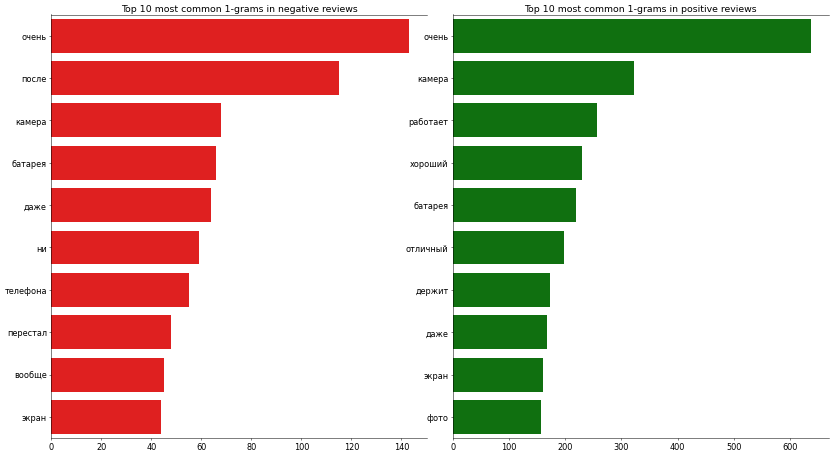

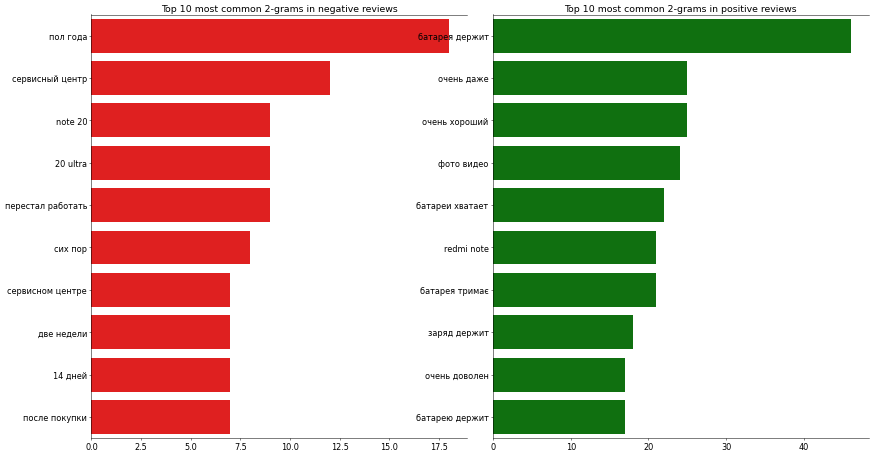

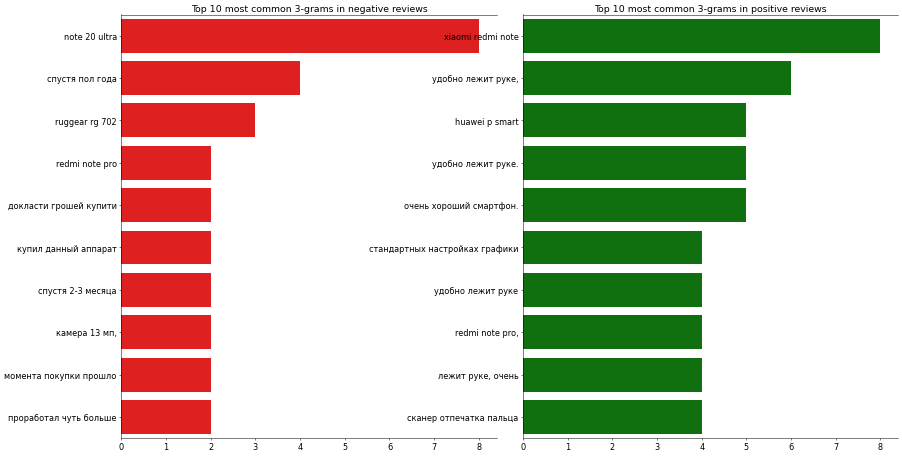

In [246]:
#View Unigrams, Bigrams, Trigrams
create_view_of_n_grams(1)
create_view_of_n_grams(2)
create_view_of_n_grams(3)

*From the generated plots we can see that unigrams are pretty similar for negative and plosive reviews, while bigrams and trigrams differ much more and also make much more sense as they catch more context from the text.*

*In case of using these features in modeling it’s advisable to explore most common unigrams in more depth. 
Possibly it’s better to use only bigrams and trigrams as features for modeling as unigrams might not capture the context of positive or negative sentiment.*

##  review_text - Meta Features analysis
Lets have a look at meta Features of review_text:
- word_count - number of words in text
- unique_word_count - number of unique words in text
- stop_word_count - number of stop words in text
- mean_word_length - average character count in words
- char_count - number of characters in text
- punctuation_count - number of punctuations in text
- stop_word_count - number of stopwords in text

In [247]:
#Define Function to calculate Meta Features
punctuation = ['#', '@', '!', '?', '+', '&', '-', '$', '=', '<', '>', '|', '{', '}', '^', "'", '(', ')' , '[', ']', '*', '%', '...', "'", ".", ':', ';']
def calculate_meta_features (dataframe, text_column):
### This functions adds text meta_features to dataframe: word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count, stop_word_count 
    # word_count
    dataframe.loc[:, 'word_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len(str(x).split()))
    # unique_word_count
    dataframe.loc[:, 'unique_word_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len(set(str(x).split())))
    # mean_word_length
    dataframe.loc[:, 'mean_word_length_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    # char_count
    dataframe.loc[:, 'char_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len(str(x)))
    # punctuation_count
    dataframe.loc[:, 'punctuation_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len([c for c in str(x) if c in punctuation]))
    # stop_word_count
    dataframe.loc[:, 'stop_word_count_{}'.format(text_column)] = dataframe[text_column].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

#Calculate Meta Features of review_text using function
calculate_meta_features(review_text_clean, 'review_text')

In [248]:
review_text_clean.head()

product_link  \
1  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
2  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
5  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
6  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
8  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   

                                                                                                                 product_title  \
1   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
2   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
5   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
6   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
8   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    

   product_price  review_id review_date  \
1  39999.0        49190491  2021-02-04    
2  39999.0        49299159  2021-02-14    
5  39999.0        49228123  2021-02-08    
6  39999.0        49212385  2021-02-06    
8  39999.0        49285480  2021-02-12    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             review_text  \
1  Датчик адаптивной яркости работает не корректно в темноте дисплей светит на 90 процентов. Когда тресешь телефон раздается звук как будто внутри что то отвалилось, до этого s9 plus таких проблем не было, да Самсунг уже не тот))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
2  Я не буду расписывать плюсы телефона - о них можно почитать в обзорах. Поэтому напишу о том, почему лично у меня с телефоном пока не сложились отношения. Отпечаток пальца работает плохо. То срабатывает без проблем, то с 5й попытки не желае

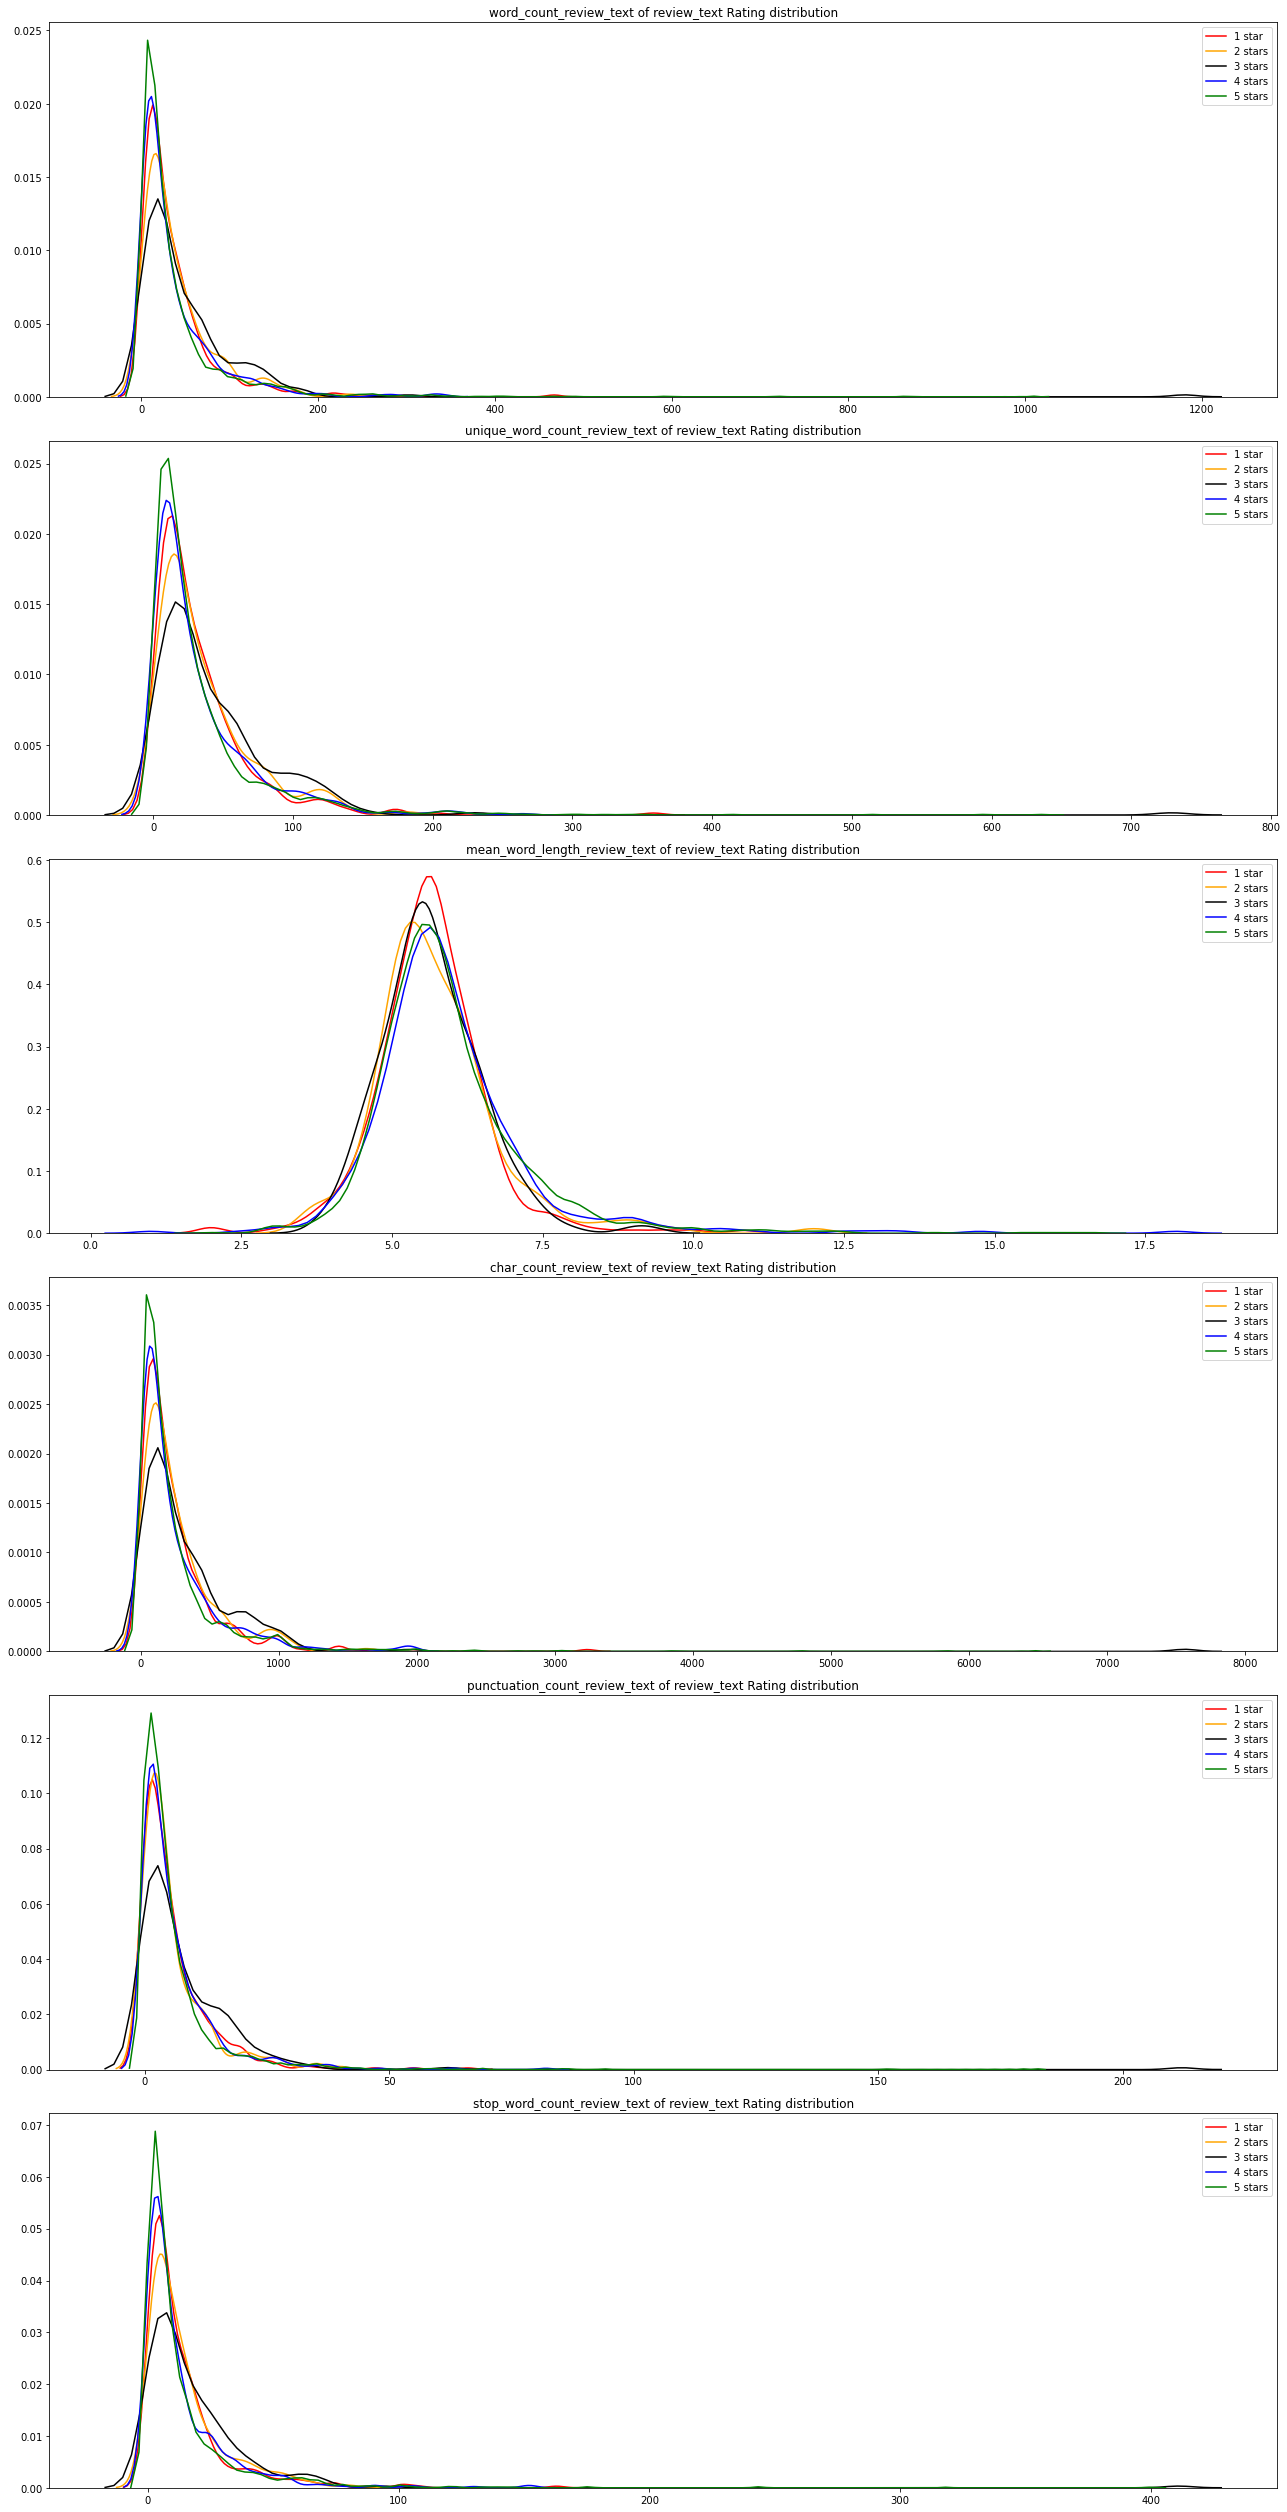

In [249]:
#Plot meta features distribution in relation to Target variable - Review rating
fig, axes = plt.subplots(6, figsize=(18,35))
for count, column in enumerate(['word_count_review_text', 'unique_word_count_review_text', 'mean_word_length_review_text', 'char_count_review_text', 'punctuation_count_review_text', 'stop_word_count_review_text']):
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 1.0][column], shade=False, color='red', label ='1 star')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 2.0][column], shade=False, color='orange', label ='2 stars')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 3.0][column], shade=False, color='black', label ='3 stars')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 4.0][column], shade=False, color='blue', label ='4 stars')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_rating'] == 5.0][column], shade=False, color='green', label ='5 stars')
    axes[count].set_title('{} of review_text Rating distribution'.format(column))
fig.tight_layout()

*From the plots we can see that distribution of almost all meta features of review_text differ quite a lot for reviews with different rating.*

*But generated plots look pretty cluttered, let’s simplify them by displaying distribution of review_text meta features only for negative and positive reviews.*

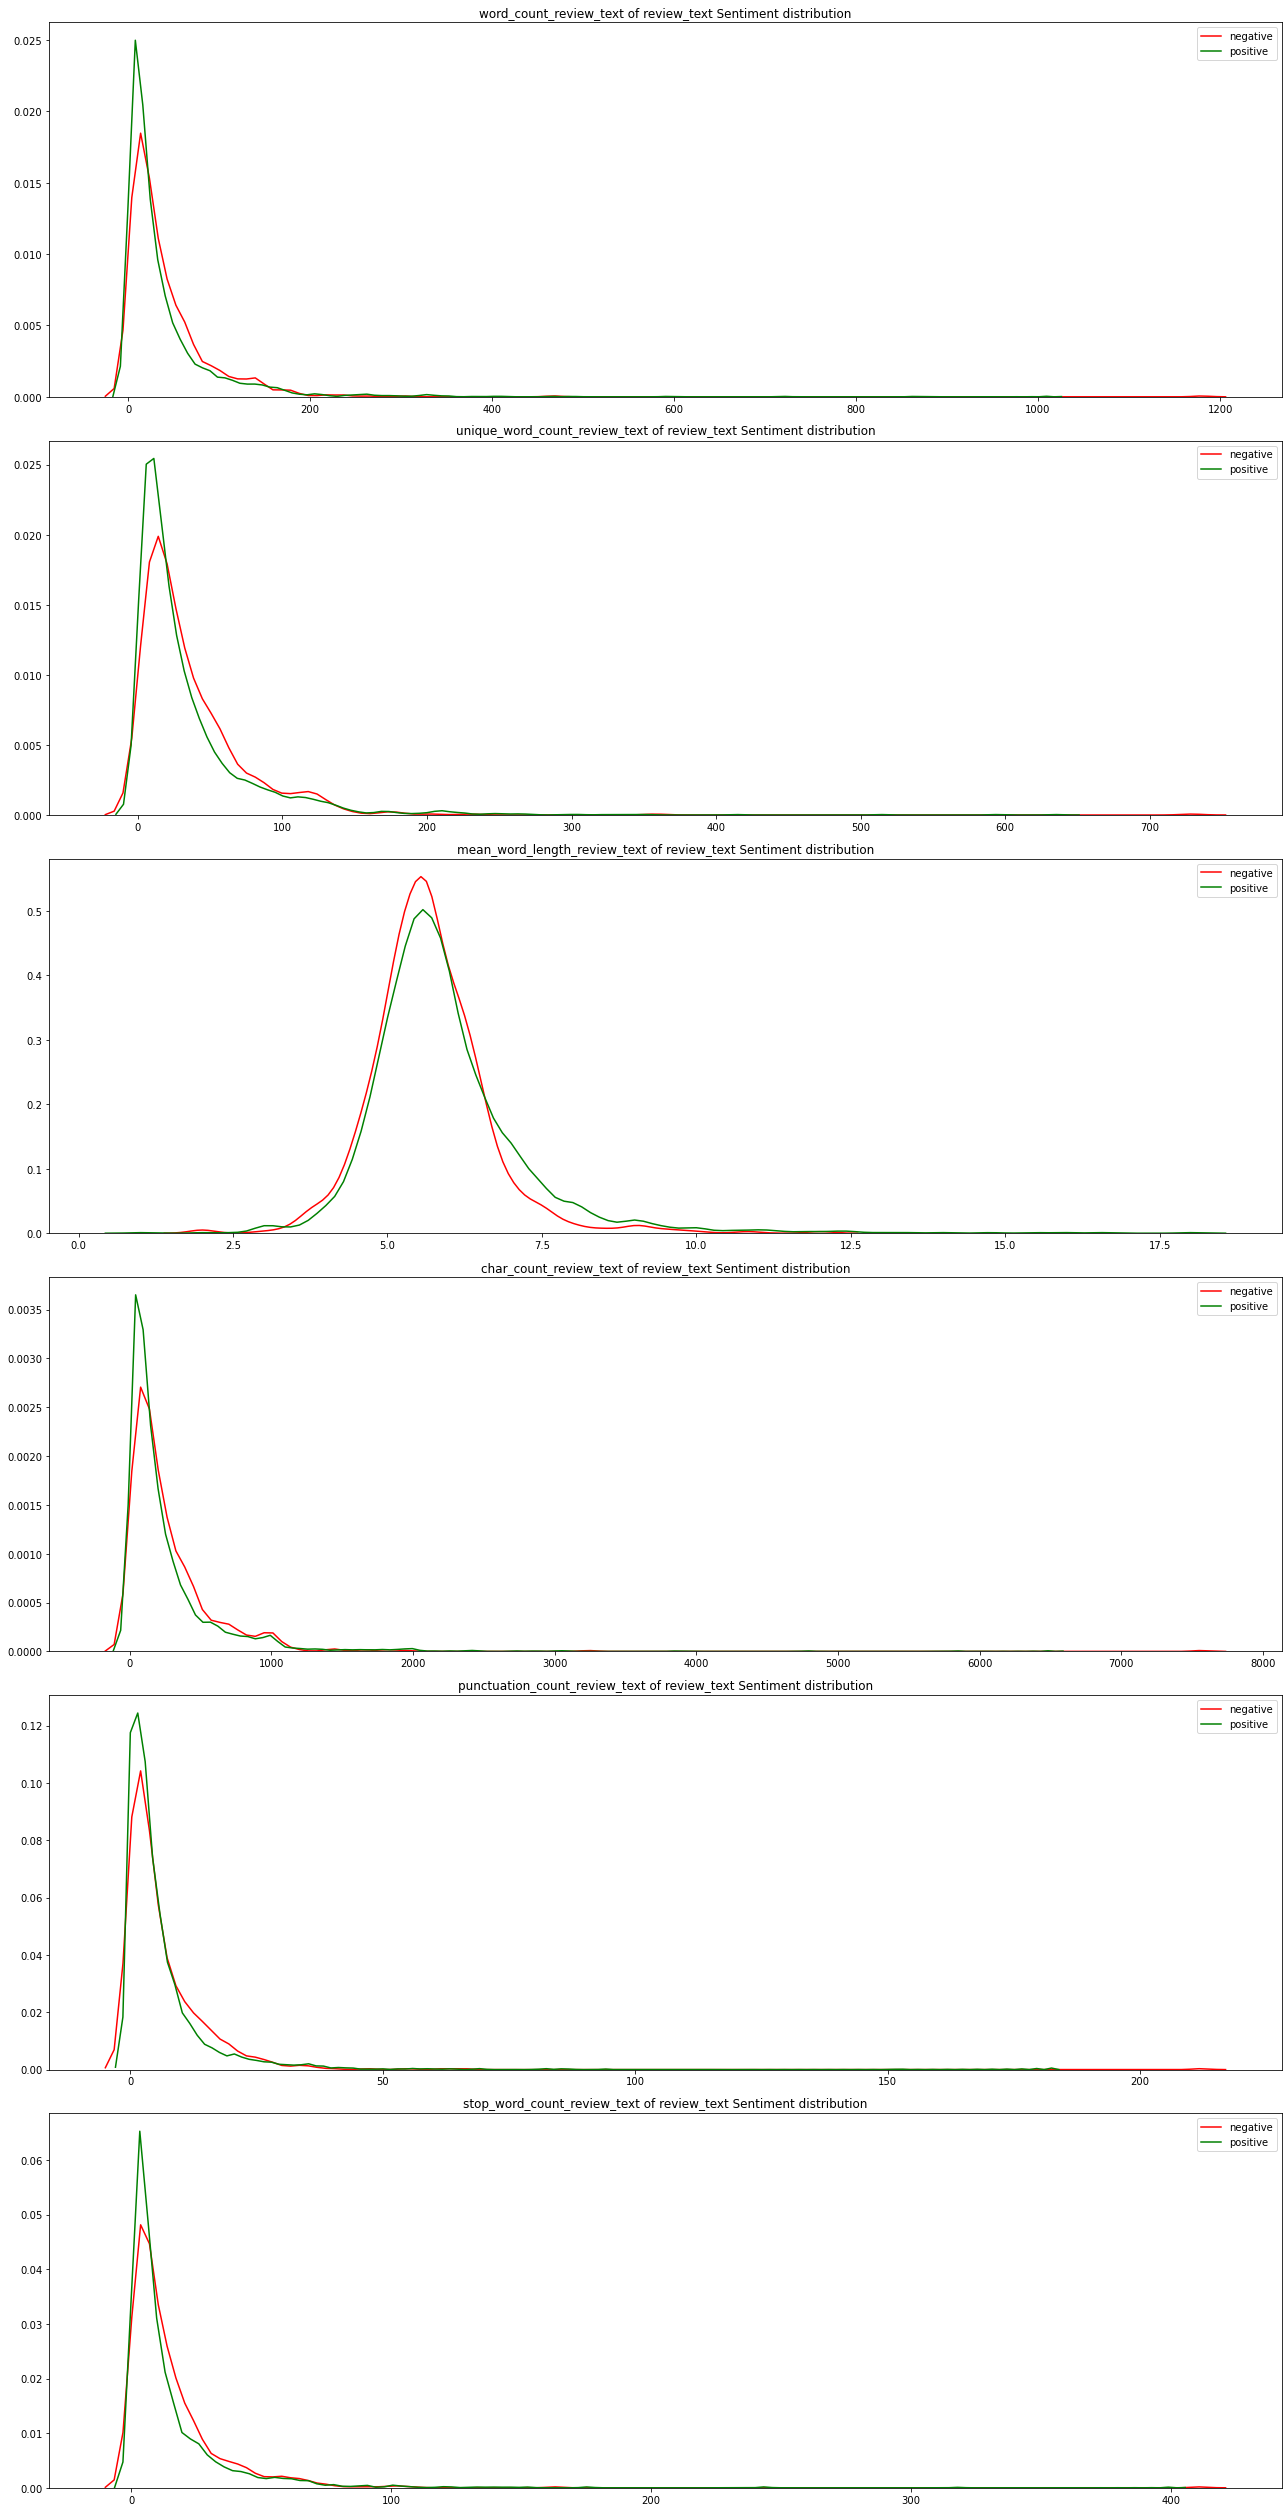

In [250]:
#Plot meta features distribution in relation to simplified Target variable - Review rating
fig, axes = plt.subplots(6, figsize=(18,35))
for count, column in enumerate(['word_count_review_text', 'unique_word_count_review_text', 'mean_word_length_review_text', 'char_count_review_text', 'punctuation_count_review_text', 'stop_word_count_review_text']):
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_sentiment'] == '0'][column], shade=False, color='red', label ='negative')
    sns.kdeplot(ax = axes[count], data=review_text_clean[review_text_clean['review_sentiment'] == '1'][column], shade=False, color='green', label ='positive')
    axes[count].set_title('{} of review_text Sentiment distribution'.format(column))
fig.tight_layout()

*Distributions of majority of meta features are different for reviews with negative and positive sentiment. These features can be helpful in modeling stage.*

##  product_advatages - Meta Features analysis

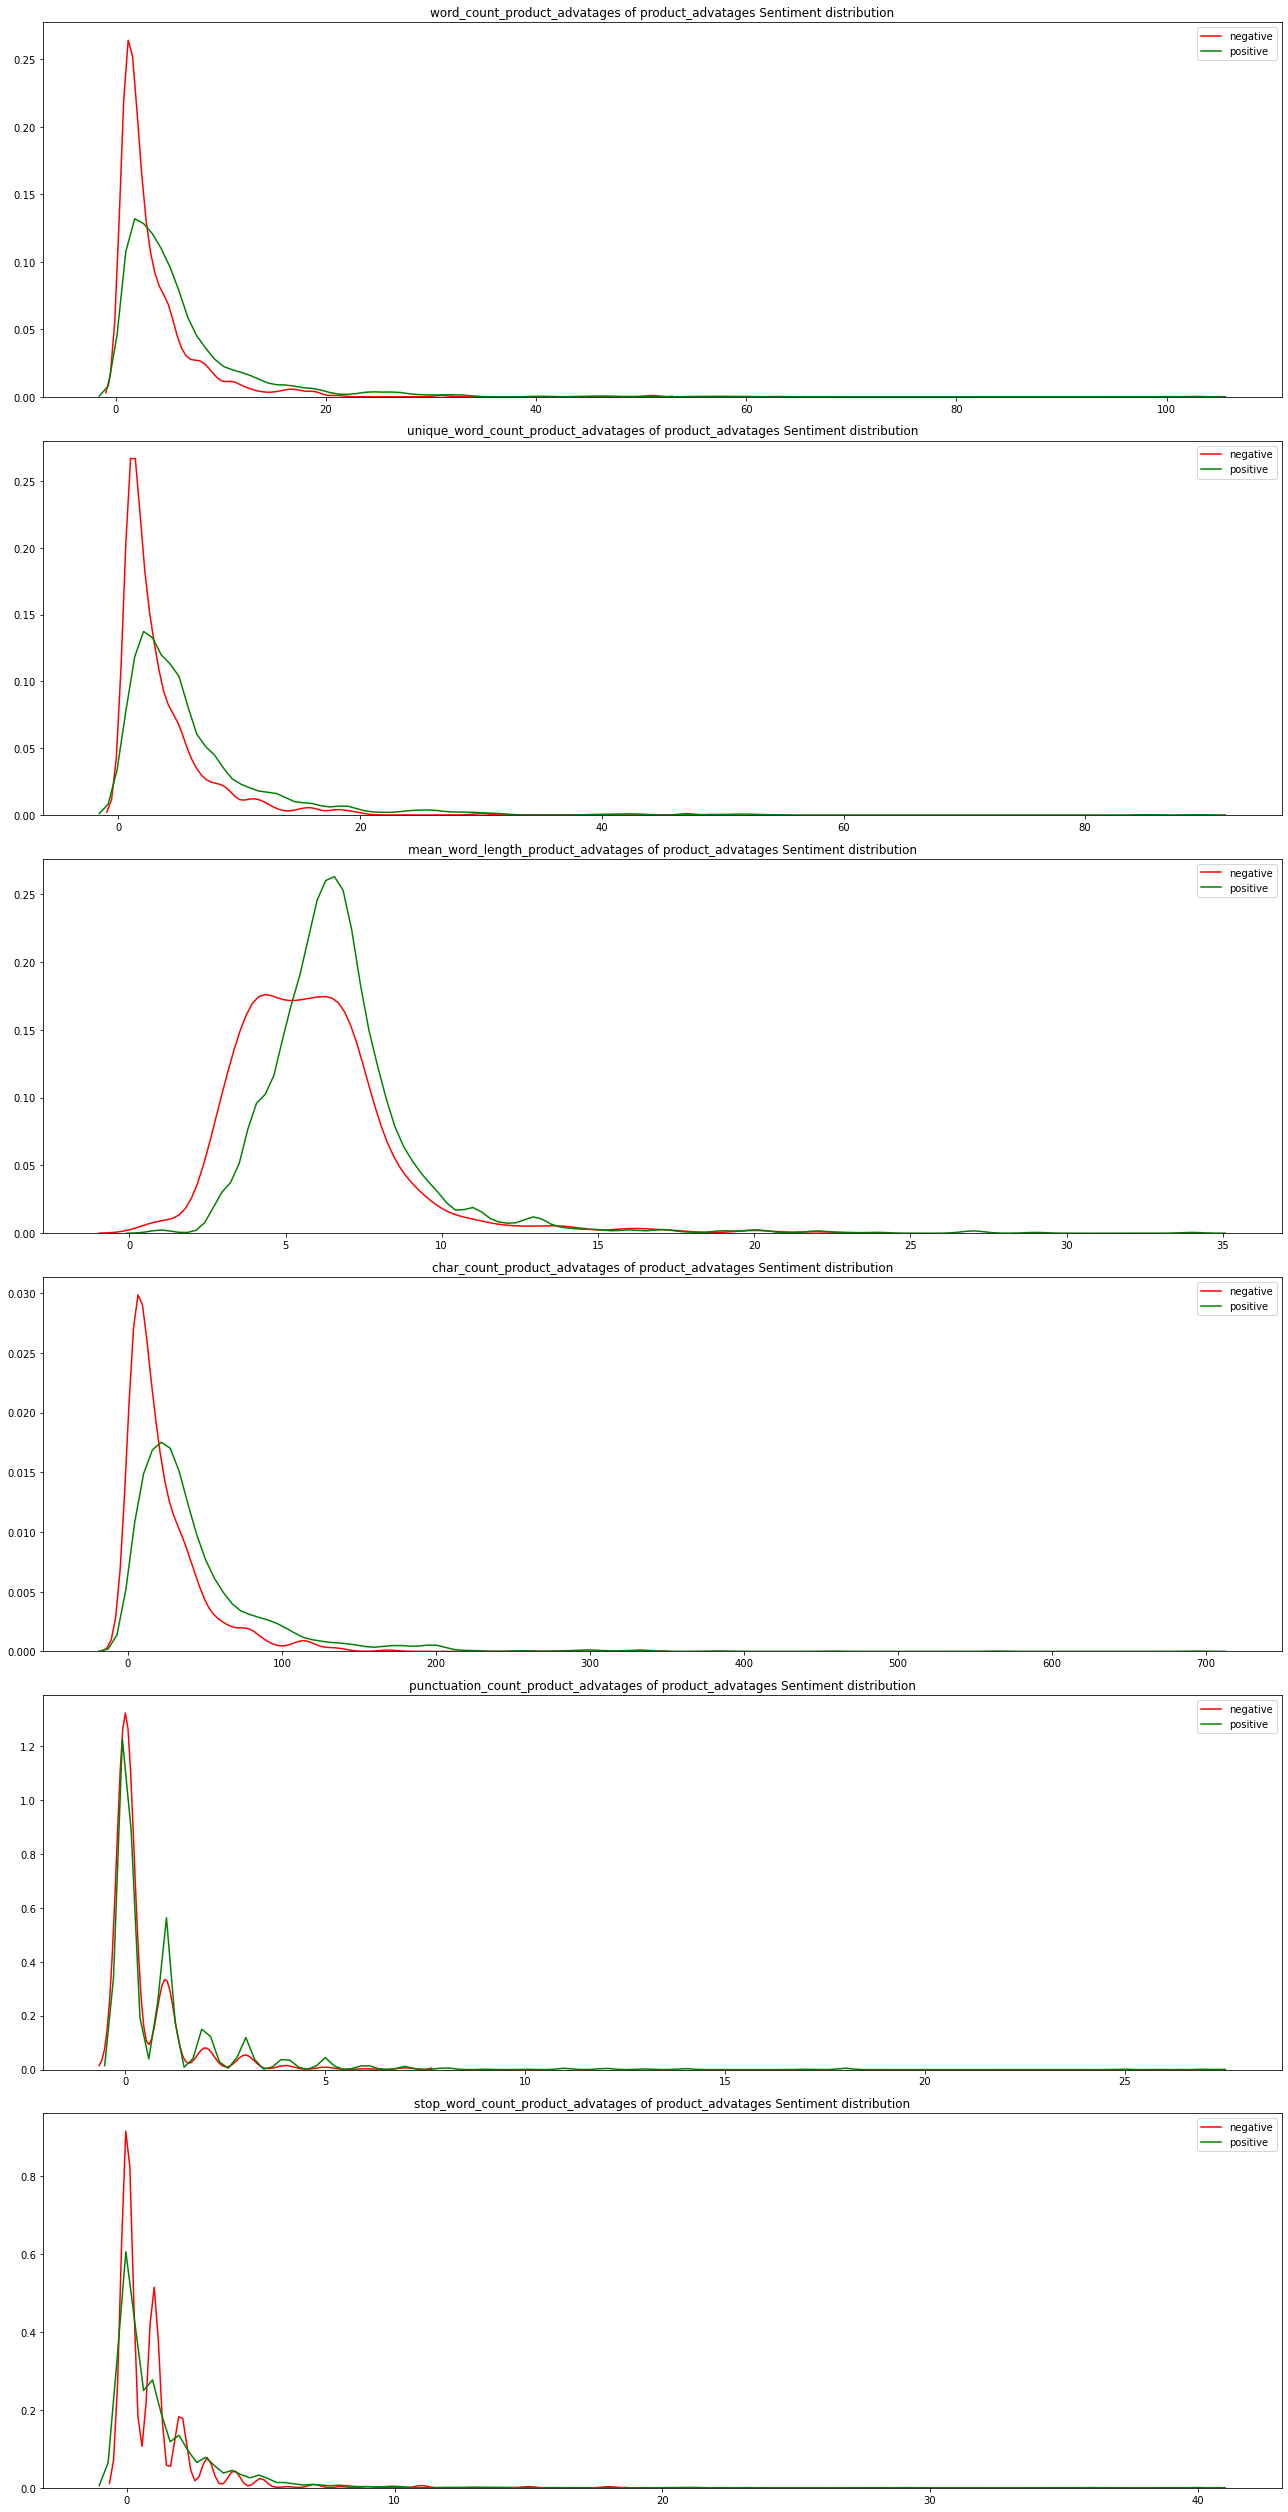

In [251]:
#Lets remove rows with empty review text and calculate meta features
product_advatages_clean = pd.DataFrame(data_wth_rating.dropna(subset = ['product_advatages']))

#Calculate Meta Features of product_advatages using function
calculate_meta_features(product_advatages_clean, 'product_advatages')

#Plot meta features distribution in ralation to  simplified Target variable - Review rating
fig, axes = plt.subplots(6, figsize=(18,35))
for count, column in enumerate(['word_count_product_advatages', 'unique_word_count_product_advatages', 'mean_word_length_product_advatages', 'char_count_product_advatages', 'punctuation_count_product_advatages', 'stop_word_count_product_advatages']):
    sns.kdeplot(ax = axes[count], data=product_advatages_clean[product_advatages_clean['review_sentiment'] == '0'][column], shade=False, color='red', label ='negative')
    sns.kdeplot(ax = axes[count], data=product_advatages_clean[product_advatages_clean['review_sentiment'] == '1'][column], shade=False, color='green', label ='positive')
    axes[count].set_title('{} of product_advatages Sentiment distribution'.format(column))
fig.tight_layout()

*Distributions of majority of meta features are different for negative and positive reviews. punctuation_count and stop_word_count might be not good enough, but other features can be helpful in modeling stage.*

##  product_disadvantages - Meta Features analysis 

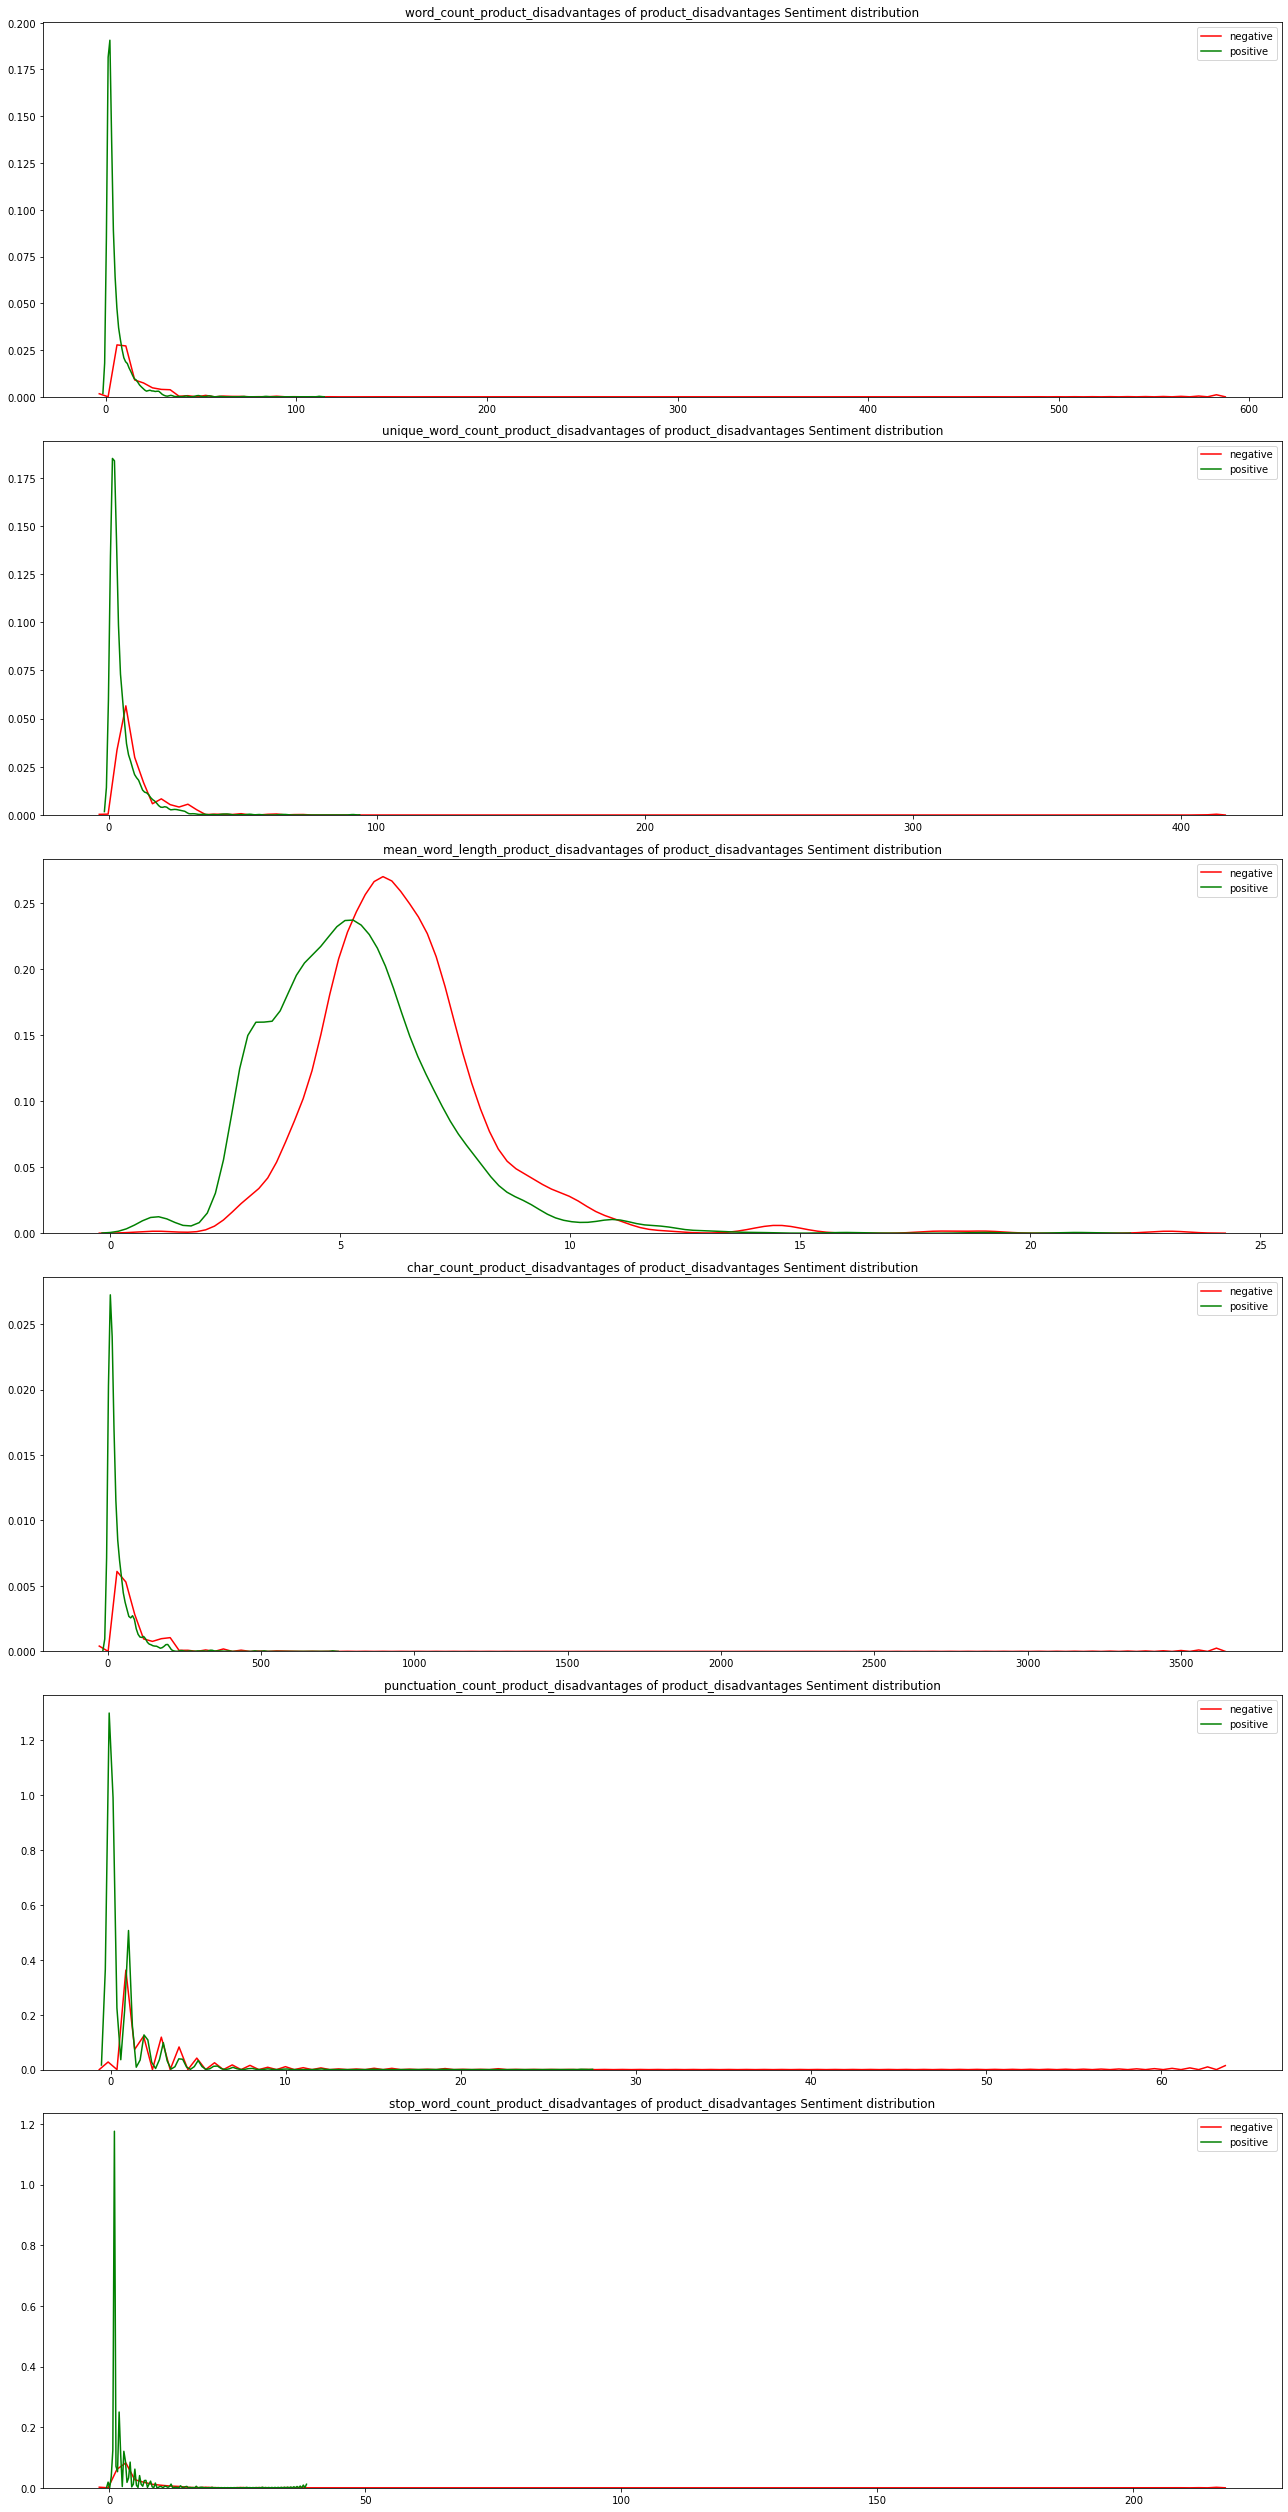

In [252]:
#Lets remove rows with empty review text and calculate meta features
product_disadvantages_clean = pd.DataFrame(data_wth_rating.dropna(subset = ['product_disadvantages']))

#Calculate Meta Features of product_disadvantages using function
calculate_meta_features(product_disadvantages_clean, 'product_disadvantages')

#Plot meta features distribution in ralation to  simplified Target variable - Review rating
fig, axes = plt.subplots(6, figsize=(18,35))
for count, column in enumerate(['word_count_product_disadvantages', 'unique_word_count_product_disadvantages', 'mean_word_length_product_disadvantages', 'char_count_product_disadvantages', 'punctuation_count_product_disadvantages', 'stop_word_count_product_disadvantages']):
    sns.kdeplot(ax = axes[count], data=product_disadvantages_clean[product_disadvantages_clean['review_sentiment'] == '0'][column], shade=False, color='red', label ='negative')
    sns.kdeplot(ax = axes[count], data=product_disadvantages_clean[product_disadvantages_clean['review_sentiment'] == '1'][column], shade=False, color='green', label ='positive')
    axes[count].set_title('{} of product_disadvantages Sentiment distribution'.format(column))
fig.tight_layout()

*Distributions of all meta features are different for negative and positive reviews. These features can be helpful in modeling stage.*

# Step 4: Biulding prediction model with BERT

For this project of text classification by predicting review sentiment it’s suggested to use the BERT model (Bidirectional Encoder Representations from Transformers).

Nowadays it is a very popular model which currently provides outstanding results in text processing because of it bidirectional approach and allows to have a deeper sense of language context and flow than single-direction language models. 

To build the model we will use Ktrain - a lightweight wrapper for TensorFlow.Keras and many other libraries, which will allow to use state-of-the-art machine learning model with much fewer coding required.

## Preprocessing: Drop rows with missing values

In [253]:
#Drop rows without rating to train the model on labels data
data_clean = data.dropna(subset = ['review_rating'])

#Drop rows without review_text, product_advatages, product_disadvantages as for these rows we don't have enough information to make prediction
data_clean = data_clean.dropna(subset = ['full_text'])

data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3389 entries, 1 to 5395
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   product_link           3389 non-null   object        
 1   product_title          3389 non-null   object        
 2   product_price          3389 non-null   float64       
 3   review_id              3389 non-null   int64         
 4   review_date            3389 non-null   datetime64[ns]
 5   review_text            3338 non-null   object        
 6   review_rating          3389 non-null   float64       
 7   thumbs_up              3389 non-null   int64         
 8   thumbs_down            3389 non-null   int64         
 9   product_advatages      2552 non-null   object        
 10  product_disadvantages  2488 non-null   object        
 11  full_text              3389 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory u

In [254]:
#Check rows with empty review_text, product_advatages, product_disadvantages   
data_clean[data_clean.review_text.isna()&(data_clean.product_advatages.isna()&data_clean.product_disadvantages.isna())]

Empty DataFrame
Columns: [product_link, product_title, product_price, review_id, review_date, review_text, review_rating, thumbs_up, thumbs_down, product_advatages, product_disadvantages, full_text]
Index: []

In [255]:
#Check rows with empty review text, but not empty product_advatages, product_disadvantages to see if there is enough information for model training
data_clean[data_clean.review_text.isna()&(data_clean.product_advatages.notna()|data_clean.product_disadvantages.notna())]

product_link  \
69    https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432           
256   https://rozetka.com.ua/ua/motorola_page0015rs/p245661253/comments/#id=49220436                        
390   https://rozetka.com.ua/ua/xiaomi_redmi_note_9_3_64gb_midnight_grey/p209754337/comments/#id=49359517   
821   https://rozetka.com.ua/ua/apple_mhdm3/p260937056/comments/#id=49077362                                
1291  https://rozetka.com.ua/ua/meizu_m6t_2_16gb_black_106738/p111954806/comments/#id=44708245              
1301  https://rozetka.com.ua/ua/vivo_y1s_2_32gb_black/p237030031/comments/#id=47514733                      
1944  https://rozetka.com.ua/ua/71671101/p71671101/comments/#id=44725464                                    
1959  https://rozetka.com.ua/ua/55904076/p55904076/comments/#id=36278011                                    
1975  https://rozetka.com.ua/ua/28782137/p28782137/comments/#id=37637192                                    
2105  https://rozetka.com.ua/ua/samsung_galaxy_m31_6_128gb_blue/p175401451/comments/#id=49289159            
2182  https://rozetka.com.ua/ua/apple_iphone_11_pro_max_64gb_space_gray/p137227775/comments/#id=48007272    
2224  https://rozetka.com.ua/ua/nokia_2_3_2_32gb_black/p159096638/comments/#id=48873913                     
2226  https://rozetka.com.ua/ua/nokia_2_3_2_32gb_black/p159096638/comments/#id=48873913                     
2437  https://rozetka.com.ua/ua/apple_iphone_11_pro_64gb_space_gray/p135813894/comments/#id=49171648        
2618  https://rozetka.com.ua/ua/realme_c3_2_32gb_blue/p210636577/comments/#id=48632014                      
2715  https://rozetka.com.ua/ua/2e_e450a_2018_dualsim_black/p51927996/comments/#id=47703376                 
2864  https://rozetka.com.ua/ua/huawei_p30_aurora/p76639638/comments/#id=46822363                           
3286  https://rozetka.com.ua/ua/tecno_camon_12_air_cc6_bay_blue/p142151745/comments/#id=49246424            
3363  https://rozetka.com.ua/ua/zte_blade_v10_vita_3_64gb_green/p99194710/comments/#id=44529897             
3365  https://rozetka.com.ua/ua/assistant_as_502_shot_black/p32105951/comments/#id=47900767                 
3443  https://rozetka.com.ua/ua/zte_blade_a5_2_32gb_black/p213750829/comments/#id=48313199                  
3587  https://rozetka.com.ua/ua/tecno_pouvoir_2_la7_pro_gold/p55399962/comments/#id=42836696                
3627  https://rozetka.com.ua/ua/prestigio_psp3515duoblack/p63313990/comments/#id=47683075                   
3633  https://rozetka.com.ua/ua/tecno_4895180747427/p102580422/comments/#id=47491871                        
3649  https://rozetka.com.ua/ua/doogee_y7_obsidian_black/p70934534/comments/#id=47677863                    
3753  https://rozetka.com.ua/ua/impression_imsmart_c571/p18132564/comments/#id=44028323                     
4096  https://rozetka.com.ua/ua/117931855/p117931855/comments/#id=46900238                                  
4234  https://rozetka.com.ua/ua/xiaomi_redmi_note_9s_6_128gb_grey/p204698749/comments/#id=46321211          
4301  https://rozetka.com.ua/ua/107415330/p107415330/comments/#id=44029149                                  
4421  https://rozetka.com.ua/ua/71671107/p71671107/comments/#id=45431142                                    
4433  https://rozetka.com.ua/ua/55909158/p55909158/comments/#id=44982028                                    
4436  https://rozetka.com.ua/ua/55909158/p55909158/comments/#id=44982028                                    
4510  https://rozetka.com.ua/ua/68057099/p68057099/comments/#id=45520834                                    
4593  https://rozetka.com.ua/ua/51610266/p51610266/comments/#id=34277465                                    
4674  https://rozetka.com.ua/ua/91537100/p91537100/comments/#id=45043189                                    
4721  https://rozetka.com.ua/ua/73796121/p73796121/comments/#id=46103491                                    
4984  https://rozetka.com.ua/ua/66806117/p66806117/comments/

*From table above we see that majority of records with empty review_text have useful information in product_advatages, product_disadvantages columns, so we will keep these recods*

## Preprocessing: Preparation of target variable 

We will train a model to predict sentiment of review based on it's text. Target variable (review sentiment) will be calculated based on review_rating column:
- positive sentiment will have the value “1” and correspond to rating of 4 and 5 stars;
- negative sentiment will have the value “0” and correspond to rating of 1, 2 and 3 stars.

In [258]:
#Create new column review_sentiment for target variable
data_clean.loc[(data_clean['review_rating']==1)|(data_clean['review_rating']==2)|(data_clean['review_rating']==3), 'review_sentiment'] = '0' 
data_clean.loc[(data_clean['review_rating']==4)|(data_clean['review_rating']==5), 'review_sentiment'] = '1'
display(data_clean.review_sentiment.head())

1    0
2    0
5    0
6    0
8    1
Name: review_sentiment, dtype: object

In [259]:
#Check proportions of negative and positive reviews
display(round(data_clean.groupby('review_sentiment')['product_link'].count()/data_clean.shape[0], 2))

review_sentiment
0    0.24
1    0.76
Name: product_link, dtype: float64

*Class distribution of target variable is imbalanced, 75% of all reviews are positive.*

In [260]:
#Encode target variable (format required for the modeling)
target = pd.get_dummies(data_clean.review_sentiment)
data_clean['0'] = target.iloc[:, 0]
data_clean['1'] = target.iloc[:, 1]

## Preprocessing: train/test split and preprocessing pipeline with Bert mode

For training the model we will use the column full_text which contains all text from reviews (review_text, product_advatages, product_disadvantages). 

In [261]:
#Split dataset into training and test. Test dataframe can be used later to check model performance on the unseen data.
#Add stratify parameter to ensure the same proportions of examples in each class as observed in the original dataset.
df_train, df_test = train_test_split(data_clean, test_size=0.2, stratify=data_clean.review_sentiment)

In [262]:
#Check proportions of examples in each class for training and test dataset.
display(round(df_test.groupby('review_sentiment')['review_id'].count()/df_test.shape[0], 2))
display(round(df_train.groupby('review_sentiment')['review_id'].count()/df_train.shape[0], 2))

review_sentiment
0    0.24
1    0.76
Name: review_id, dtype: float64

review_sentiment
0    0.24
1    0.76
Name: review_id, dtype: float64

In [263]:
#Data preprocessing with bert mode
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df_train, 
                                                                   'full_text', # name of column containing review text
                                                                   label_columns=['0', '1'],
                                                                   maxlen=200, 
                                                                   max_features=100000,
                                                                   preprocess_mode='bert',
                                                                   val_pct=0.1)

preprocessing train...
language: ru


Is Multi-Label? False
preprocessing test...
language: ru


## Building Bert model with ktrain

In [264]:
#Initializing pre-trained Bert model
model = text.text_classifier(name='bert',
                             train_data=(x_train, y_train),
                             preproc=preproc)

Is Multi-Label? False
maxlen is 200
done.


In [265]:
#View loaded model architecture summary
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 200)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 200, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 200, 768)     1536        Input-Segment[0][0]              
_______________________________________________________________________________________

In [267]:
#Wrap the model and data in a Learner object
learner = ktrain.get_learner(model=model,
                             train_data=(x_train, y_train),
                             val_data=(x_test, y_test),
                             batch_size=6)

**Learning Rate Finder**
The Learner object can be used to find a good learning rate for the model using the lr_find and lr_plot methods. The lr_find method simulates training at different learning rates and tracks the loss. After visually inspecting the plot generated by lr_plot, we choose the highest learning rate still associated with the smallest loss - 1e-5

In [353]:
#Run Learning Rate Finder
learner.lr_find(max_epochs=1)

simulating training for different learning rates... this may take a few moments...
395/395 [==============================] - 2848s 7s/step - loss: 0.7970 - accuracy: 0.7610


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


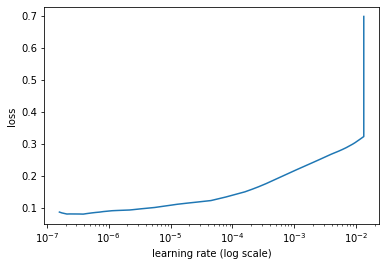

In [354]:
#Visually inspect the loss plot 
learner.lr_plot() 

**Weight decay** 
Weight decay is a form of regularization, we will use it in order to reduce overfitting caused by targer classes imbalance.
By default, ktrain uses no weight decay, but for our model we will set default weight decay rate of 0.01 implemented using the AdamWeightDecay optimizer.

In [268]:
#Set learner to use default weight decay rate 
learner.get_weight_decay()
learner.set_weight_decay()

C:\Users\Anna\anaconda3\lib\site-packages\ktrain\core.py:357: UserWarning: recompiling model to use AdamWeightDecay as opimizer with weight decay of 0.01
  warnings.warn('recompiling model to use AdamWeightDecay as opimizer with weight decay of %s' % (wd) )


In [269]:
#Create TensorBoard calback to use it later to analyse model performance
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='/tmp/Tensor_Board', histogram_freq=0, write_graph=True, write_images=True)

#Training the model
learner.fit_onecycle(lr=1e-5,
                     epochs=3,
                    callbacks=[tbCallBack])



begin training using onecycle policy with max lr of 1e-05...
Epoch 1/3
395/395 [==============================] - 2698s 7s/step - loss: 0.5480 - accuracy: 0.7546 - val_loss: 0.4080 - val_accuracy: 0.8182
Epoch 2/3
395/395 [==============================] - 2764s 7s/step - loss: 0.3965 - accuracy: 0.8269 - val_loss: 0.3125 - val_accuracy: 0.8636
Epoch 3/3
395/395 [==============================] - 2871s 7s/step - loss: 0.2216 - accuracy: 0.9185 - val_loss: 0.2840 - val_accuracy: 0.8902



# Step 5: Evaluating model performance

## Check model performance metrics on the Training dataset

In [352]:
#Analyse TensorBoard graphics
%reload_ext tensorboard
%tensorboard --logdir /tmp/Tensor_Board

Reusing TensorBoard on port 6006 (pid 17264), started 2 days, 10:57:07 ago. (Use '!kill 17264' to kill it.)

In [272]:
#Check learner performance metrics
learner.validate()

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        65
           1       0.93      0.92      0.93       199

    accuracy                           0.89       264
   macro avg       0.85      0.86      0.85       264
weighted avg       0.89      0.89      0.89       264



array([[ 52,  13],
       [ 16, 183]], dtype=int64)

*From the table above we can see that the model has pretty high accuracy – 89% of predictions were correct.
Predictions for positive reviews are pretty precise: 93% of all precited reviews are truly positive and 92% of all positive reviews were detected correctly.*
*For negative reviews precision is less: only 76% of all precited reviews are truly negative and only 80% of all negative reviews were detected correctly.*
*From f1-score we can see that the model is pretty good at predicting positive reviews and works worse for predicting negative reviews which is expected due to class imbalance.*

In [274]:
#View 5 top losses of the model.
#Reviewing where model made mistakes can help to understand better how algorithm works and if anything can be improved in preprocessing stage. 
txt = learner.view_top_losses(n=5, preproc=preproc)

----------
id:220 | loss:4.87 | true:0 | pred:1)

[CLS] если кор ##от ##ко : добро ##т ##ны ##и , ф ##ун ##к ##цио ##нал ##ьны ##и теле ##фон , которым при ##ятно пол ##ь ##зова ##ться . от ##ли ##чны ##и э ##к ##ран , хор ##ош ##ая , ун ##ив ##ерс ##альная кам ##ера , много поле ##зных функции . к со ##жал ##ению , своих денег совершенно не стоит . как для самого к ##ру ##того и без ##ком ##про ##ми ##сс ##ного andro ##id см ##арт ##фон ##а на р ##ын ##ке - - слишком много ко ##м ##ром ##ис ##сов и м ##ел ##ких не ##до ##стат ##ков . по ##куп ##ать не совет ##ую , если только вы на 100 % не у ##вер ##ены , что ва ##м н ##у ##жен именно этот теле ##фон . тем более более дорог ##ую модель 12 / 512 . п ##иш ##у от ##зы ##в спустя 2 пол ##ных недели исп ##ль ##зован ##ия ( получил теле ##фон на руки 26 августа ) . за это время у ##с ##пел п ##еп ##еро ##бов ##ать большинство ф ##ич ##еи и вы ##стр ##ои ##ть свои в ##пе ##чат ##ления от у ##стр ##ои ##с [SEP]
----------
id:20 | loss:4.06 |

*From reviewing records with the biggest loss we can see that it’s understandable why the model made such predictions. If sentiment had to be set manually, for most of reviews I would choose the same value as model did. So, text of reviews might be confusing while determining sentiment.*

## Check model performance metrics on the Testing dataset

In [275]:
#Get predictor and check how it works on one record example
predictor = ktrain.get_predictor(learner.model, preproc)

In [276]:
#Make predictions on the Test dataset
df_test_pred = pd.DataFrame(df_test)
df_test_pred['bert_prediction'] = [predictor.predict(i) for i in df_test.full_text]

In [277]:
#Check datafrmae view with made predictions
df_test_pred.head(3)

product_link  \
2681  https://rozetka.com.ua/ua/vivo_y15_4_64gb_burgundy_red/p105002094/comments/#id=47199723   
751   https://rozetka.com.ua/ua/oppo_reno4_pro_8_256gb_blue/p245815987/comments/#id=49198062    
3292  https://rozetka.com.ua/ua/sigma_x_treme_pq34_black/p35607544/comments/#id=46027640        

                                            product_title  product_price  \
2681   Мобільний телефон Vivo Y15 4/64GB Burgundy Red      4499.0          
751    Мобільний телефон OPPO Reno4 Pro 8/256 GB Blue      17999.0         
3292   Мобільний телефон Sigma mobile X-treme PQ34 Black   5299.0          

      review_id review_date  \
2681  49111087  2021-01-28    
751   49214519  2021-02-06    
3292  32952624  2018-09-25    

                                                                                                                                                                 review_text  \
2681  #моєрозпакуванняХороша автономність, гарний дизайн, захисна плівка і чехол в комплекті) Покупкою задоволений)                                                            
751   Не смотря на проц телефон шикарен на свои 15555, камера это его основная фишка, фотки крутые что днем что ночью , видео максимально плавное , стабилизацию сразу видно   
3292  Никак не могу решить проблему с Вайбер. Что нужно сделать, расскажите подробнее.                                                                                         

      review_rating  thumbs_up  thumbs_down product_advatages  \
2681  4.0            0          0            Ємнісна батарея.   
751   5.0            0          0            Камера, зарядка    
3292  5.0            1          0            NaN                

           product_disadvantages  \
2681  NaN                          
751   Проц не самый конкурентный   
3292  NaN                          

                                                                                                                                                                                                                                         full_text  \
2681  #моєрозпакуванняХороша автономність, гарний дизайн, захисна плівка і чехол в комплекті) Покупкою задоволений) Преймущества: Ємнісна батарея.. Недостатки: None                                                                                 
751   Не смотря на проц телефон шикарен на свои 15555, камера это его основная фишка, фотки крутые что днем что ночью , видео максимально плавное , стабилизацию сразу видно Преймущества: Камера, зарядка. Недостатки: Проц не самый конкурентный   
3292  Никак не могу решить проблему с Вайбер. Что нужно сделать, расскажите подробнее. Преймущества: None. Недостатки: None                                                                                                                          

     review_sentiment  0  1 bert_prediction  
2681  1                0  1  1               
751   1                0  1  1               
3292  1                0  1  1

*Test data set can be used to evaluate performance of the model on the unseen by model data. It will help to confirm model performance results and define if there are any overfitting issues.*

In [383]:
#Check proportions of predicted class for test dataset.
display(round(df_test_pred.groupby('bert_prediction')['review_id'].count()/df_test_pred.shape[0], 2))

bert_prediction
0    0.28
1    0.72
Name: review_id, dtype: float64

In [284]:
#Check model perfomance merics
print("Accuracy score of model's predictions on test dataset is {}".format(round(accuracy_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction), 4)))
print("Area Under the Receiver Operating Characteristic Curve on test dataset is {}. It means that there is a {}% chance that the model will be able to distinguish between positive and negative class for reviews.".format(round(roc_auc_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction), 2),round(roc_auc_score(df_test_pred.review_sentiment, df_test_pred.bert_prediction)*100, 1)))

Accuracy score of model's predictions on test dataset is 0.8877
Area Under the Receiver Operating Characteristic Curve on test dataset is 0.87. It means that there is a 87.2% chance that the model will be able to distinguish between positive and negative class for reviews.


In [384]:
#Check confusion matrix
pd.DataFrame(confusion_matrix(df_test_pred.review_sentiment, df_test_pred.bert_prediction), 
             columns=['Predicted class 0', 'Predicted class 1'],
            index=['True class 0', 'True class 1'])

Predicted class 0  Predicted class 1
True class 0  134                25               
True class 1  49                 451

*From confusion matrix above we can see the same situation as in training data set, on positive reviews model performing much better than on negative reviews.*

In [280]:
pd.DataFrame(confusion_matrix(df_test_pred.review_sentiment, df_test_pred.bert_prediction, normalize='true'), 
             columns=['Predicted class 0', 'Predicted class 1'],
            index=['True class 0', 'True class 1'])

Predicted class 0  Predicted class 1
True class 0  0.842767           0.157233         
True class 1  0.098000           0.902000

*Table above shows that 84% of all negative reviews were detected correctly, while for positive class it is 90%.*

In [281]:
pd.DataFrame(confusion_matrix(df_test_pred.review_sentiment, df_test_pred.bert_prediction, normalize='pred'), 
             columns=['Predicted class 0', 'Predicted class 1'],
            index=['True class 0', 'True class 1'])

Predicted class 0  Predicted class 1
True class 0  0.73224            0.052521         
True class 1  0.26776            0.947479

*Table above shows that 73% of all predictions as class 'negative' were correct, while almost 95% of predictions of class  'positive' were correct.*

# Step 6: Predict sentiment for reviews without rating

In [371]:
#Drop recods without text
data_to_pred = data.dropna(subset = ['full_text'])
#Select records without rating
data_to_pred = data_to_pred[data_to_pred.review_rating.isna()]
data_to_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1790 entries, 0 to 5430
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   product_link           1790 non-null   object        
 1   product_title          1790 non-null   object        
 2   product_price          1790 non-null   float64       
 3   review_id              1790 non-null   int64         
 4   review_date            1790 non-null   datetime64[ns]
 5   review_text            1735 non-null   object        
 6   review_rating          0 non-null      float64       
 7   thumbs_up              1790 non-null   int64         
 8   thumbs_down            1790 non-null   int64         
 9   product_advatages      754 non-null    object        
 10  product_disadvantages  800 non-null    object        
 11  full_text              1790 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory u

In [372]:
#Make predictions of sentiment for reviews without rating
data_to_pred['bert_prediction'] = [predictor.predict(i) for i in data_to_pred.full_text]

In [373]:
display(data_to_pred.head(20))

product_link  \
0   https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
7   https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   
11  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49366754                             
19  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49366754                             
22  https://rozetka.com.ua/ua/samsung_sma715fzbusek/p174226312/comments/#id=49366754                             
25  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49159463              
29  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49159463              
33  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49159463              
34  https://rozetka.com.ua/ua/apple_iphone_12_pro_max_128gb_silver/p245162461/comments/#id=49159463              
40  https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49345727                            
43  https://rozetka.com.ua/ua/samsung_sm_a025fzkesek/p268107536/comments/#id=49345727                            
55  https://rozetka.com.ua/ua/samsung_sm_a315fzwvsek/p199478977/comments/#id=49389613                            
64  https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                  
70  https://rozetka.com.ua/ua/apple_iphone_12_64gb_product_red/p245162161/comments/#id=48857432                  
73  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49291997                 
75  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49291997                 
76  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49291997                 
81  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49291997                 
83  https://rozetka.com.ua/ua/nokia_5_3_4_64gb_dualsim_charcoal/p197545181/comments/#id=49291997                 
86  https://rozetka.com.ua/ua/samsung_sm_a515fzkwsek/p168813961/comments/#id=49229688                            

                                                                                                                  product_title  \
0    Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
7    Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    
11   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
19   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
22   Мобільний телефон Samsung Galaxy A71 6/128GB Blue (SM-A715FZBUSEK)                                                           
25   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
29   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
33   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
34   Мобільний телефон Apple iPhone 12 Pro Max 128 GB Silver Офіційна гарантія                                                    
40   Мобільний телефон Samsung Galaxy A02s 3/32 GB Black (SM-A025FZKESEK)                                                         
43   Мобільний телефон Samsung Galaxy A02s 3/32 GB Black (SM-A025FZKESEK)                                                         
55   Мобільний телефон Samsung Galaxy A31 4/128GB Prism Crush White (SM-A315FZWVSEK)                                              


*From the table above we can see that the quality of some reviews are low as they contain rather questions or statements that are not related to the sentiment about product. 
From inspecting the 20 displayed records I would say that 13 records contain feedback about product, 3 records contain sentiment about the service in shop and 4 records contain questions/opinions that are hard to classify as positive or negative towards product or shop. If it necessary to get higher percent of records which contain feedback about product - simply way to do so can be to filter records with longer text and check the results. From previewing these 20 records seems like records with longer have higher quality of feedback.
If we estimate how accurate are classification of sentiment which person express in text – I would say  that 17 records were classified correctly and  3 records were mislabeled, which results in accuracy 85% which is close to what we got on testing set.*

So, we can make a conclusion that the model can predict sentiment with the quite high accuracy, but it’s important to pay attention that initial data contains information about feedback about product, about shop and just question/opinions that are hard to relate to product or shop. While applying model to solve a business task or answer a business question it’s important to filter initial data first to get records that actually contain information related to subject of interest

In [382]:
#Look at proportion of predicted negative and positive sentiments
display(round(data_to_pred.groupby('bert_prediction')['review_id'].count()/data_to_pred.shape[0], 2))

bert_prediction
0    0.39
1    0.61
Name: review_id, dtype: float64

In [375]:
#Create Dataframe with column which will combine actual and predicted review sentiment 
data_to_pred['review_sentiment_actual_predicted'] = data_to_pred.bert_prediction
df_test_pred['review_sentiment_actual_predicted'] = df_test_pred.review_sentiment
df_train['review_sentiment_actual_predicted'] = df_train.review_sentiment
data_full = pd.concat([data_to_pred,df_test_pred,df_train])
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5081 entries, 0 to 3599
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   product_link                       5081 non-null   object        
 1   product_title                      5081 non-null   object        
 2   product_price                      5081 non-null   float64       
 3   review_id                          5081 non-null   int64         
 4   review_date                        5081 non-null   datetime64[ns]
 5   review_text                        4975 non-null   object        
 6   review_rating                      3291 non-null   float64       
 7   thumbs_up                          5081 non-null   int64         
 8   thumbs_down                        5081 non-null   int64         
 9   product_advatages                  3273 non-null   object        
 10  product_disadvantages              3

In [376]:
data_full.head(1)

product_link  \
0  https://rozetka.com.ua/ua/samsung_galaxy_s21_phantom_black_sm_g998bzkgsek/p272562736/comments/#id=49223834   

                                                                                                                 product_title  \
0   Мобільний телефон Samsung Galaxy S21 Ultra 12/256 GB Phantom Black (SM-G998BZKGSEK) + Сертифiкат на 4000 грн у подарунок!    

   product_price  review_id review_date  \
0  39999.0        49293156  2021-02-13    

                                                                                         review_text  \
0  Розетка, подскажите телефон без сканера лица и желательно без сканера отпечатков пальцев. Спасибо   

   review_rating  thumbs_up  thumbs_down product_advatages  \
0 NaN             0          1            NaN                

  product_disadvantages  \
0  NaN                    

                                                                                                                                full_text  \
0  Розетка, подскажите телефон без сканера лица и желательно без сканера отпечатков пальцев. Спасибо Преймущества: None. Недостатки: None   

  bert_prediction review_sentiment_actual_predicted review_sentiment   0   1  
0  1               1                                 NaN             NaN NaN

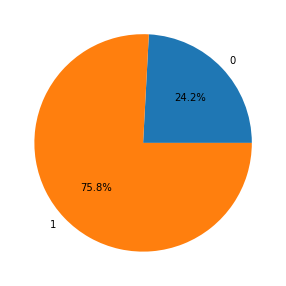

In [377]:
#Plot sentiment of text only for records with rating
labels, frequencies = np.unique(data_full.dropna(subset = ['review_rating']).review_sentiment.values, return_counts = True)
plt.figure(figsize = (5,5))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

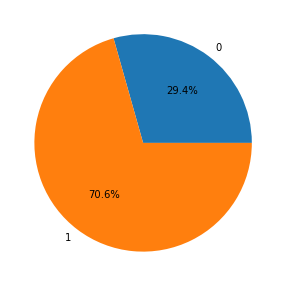

In [378]:
#Plot sentiment of text for records with rating and recods with prediction
labels, frequencies = np.unique(data_full.review_sentiment_actual_predicted.values, return_counts = True)
plt.figure(figsize = (5,5))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

*From plots above we can see the model predicts that among records without rating fraction of negative sentiment is higher than for records with rating. If we consider all records with actual rating and predicted values we can see that fraction of positive sentiment drops for 5% (from 75% to 70%) in comparison to analyzing  only records with filled rating.*